In [ ]:
%config IPCompleter.greedy=True # Enable intellisense

In [1]:
# backbone/__init__.py

import math
import torch
import torch.nn as nn

def xavier(m: nn.Module) -> None:
    """
    Applies Xavier initialization to linear modules.
    :param m: the module to be initialized
    Example::
        >>> net = nn.Sequential(nn.Linear(10, 10), nn.ReLU())
        >>> net.apply(xavier)
    """

    if m.__class__.__name__ == 'Linear':
        fan_in = m.weight.data.size(1)
        fan_out = m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def num_flat_features(x: torch.Tensor) -> int:
    """
    Computes the total number of items except the first dimension.
    :param x: input tensor
    :return: number of item from the second dimension onward
    """
    size = x.size()[1:]
    num_features = 1
    for ff in size:
        num_features *= ff
    return num_features

In [2]:
# backbone/MNISTMLP.py

import torch
import torch.nn as nn
from typing import Tuple


class MNISTMLP(nn.Module):
    """
    Network composed of two hidden layers, each containing 100 ReLU activations.
    Designed for the MNIST dataset.
    """

    def __init__(self, input_size: int, output_size: int, cluster_size: int) -> None:
        """
        Instantiates the layers of the network.
        :param input_size: the size of the input data
        :param output_size: the size of the output
        """
        super(MNISTMLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.cluster_size = cluster_size

        self.fc1 = nn.Linear(self.input_size, 100)
        self.fc2 = nn.Linear(100, 100)

        self._features = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
        )
        self.classifier = nn.Linear(100, self.output_size)
        self.classifier_cluster = nn.Linear(100, self.cluster_size)
        self.reset_parameters()

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (100)
        """
        x = x.view(-1, num_flat_features(x))
        return self._features(x)

    def reset_parameters(self) -> None:
        """
        Calls the Xavier parameter initialization function.
        """
        #self.net.apply(xavier)
        self._features.apply(xavier)
        self.classifier.apply(xavier)
        self.classifier_cluster.apply(xavier)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (output_size)
        """
        x = x.view(-1, num_flat_features(x))
        out = self._features(x)
        out1 = self.classifier(out)
        out2 = self.classifier_cluster(out)
        return out1, out2

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                    + 100 * output_size + output_size)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (input_size * 100
                    + 100 + 100 * 100 + 100 + 100 * output_size + output_size)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                   + 100 * output_size + output_size)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)

    def get_grads_list(self):
        """
        Returns a list containing the gradients (a tensor for each layer).
        :return: gradients list
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return grads

In [3]:
# utils/conf.py

import random
import torch
import numpy as np
import os

def get_device() -> torch.device:
    """
    Returns the GPU device if available else CPU.
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def base_path() -> str:
    """
    Returns the base bath where to log accuracies and tensorboard data.
    """
    return './data/'


def set_random_seed(seed: int) -> None:
    """
    Sets the seeds at a certain value.
    :param seed: the value to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def create_if_not_exists(path: str) -> None:
  """
  Creates the specified folder if it does not exist.
  :param path: the complete path of the folder to be created
  """
  if not os.path.exists(path):
      os.makedirs(path)

In [4]:
# Assess the device used
get_device()

device(type='cpu')

In [5]:
# datasets/utils/validation.py

import torch
from PIL import Image
import numpy as np
import os
import torchvision.transforms.transforms as transforms
from torchvision import datasets


class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data: torch.Tensor, targets: np.ndarray,
        transform: transforms=None, target_transform: transforms=None) -> None:
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        if isinstance(img, np.ndarray):
            if np.max(img) < 2:
                img = Image.fromarray(np.uint8(img * 255))
            else:
                img = Image.fromarray(img)
        else:
            img = Image.fromarray(img.numpy())

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

def get_train_val(train: datasets, test_transform: transforms,
                  dataset: str, val_perc: float=0.1):
    """
    Extract val_perc% of the training set as the validation set.
    :param train: training dataset
    :param test_transform: transformation of the test dataset
    :param dataset: dataset name
    :param val_perc: percentage of the training set to be extracted
    :return: the training set and the validation set
    """
    dataset_length = train.data.shape[0]
    directory = 'datasets/val_permutations/'
    create_if_not_exists(directory)
    file_name = dataset + '.pt'
    if os.path.exists(directory + file_name):
        perm = torch.load(directory + file_name)
    else:
        perm = torch.randperm(dataset_length)
        torch.save(perm, directory + file_name)
    train.data = train.data[perm]
    train.targets = np.array(train.targets)[perm]
    test_dataset = ValidationDataset(train.data[:int(val_perc * dataset_length)],
                                train.targets[:int(val_perc * dataset_length)],
                                transform=test_transform)
    train.data = train.data[int(val_perc * dataset_length):]
    train.targets = train.targets[int(val_perc * dataset_length):]

    return train, test_dataset

In [6]:
# datasets/utils/continual_dataset.py

from abc import abstractmethod
from torch import nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from typing import Tuple
from torchvision import datasets
import numpy as np


class ContinualDataset:
    """
    Continual learning evaluation setting.
    """
    NAME = None
    SETTING = None
    N_CLASSES_PER_TASK = None
    N_TASKS = None
    TRANSFORM = None

    def __init__(self, batch_size: int, validation: bool) -> None:
        """
        Initializes the train and test lists of dataloaders.
        :param args: the arguments which contains the hyperparameters
        """
        self.train_loader = None
        self.test_loaders = []
        self.i = 0
        self.batch_size = batch_size
        self.validation = validation

    @abstractmethod
    def get_data_loaders(self) -> Tuple[DataLoader, DataLoader]:
        """
        Creates and returns the training and test loaders for the current task.
        The current training loader and all test loaders are stored in self.
        :return: the current training and test loaders
        """
        pass

    @abstractmethod
    def not_aug_dataloader(self, batch_size: int) -> DataLoader:
        """
        Returns the dataloader of the current task,
        not applying data augmentation.
        :param batch_size: the batch size of the loader
        :return: the current training loader
        """
        pass

    @staticmethod
    @abstractmethod
    def get_backbone() -> nn.Module:
        """
        Returns the backbone to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_backbone_cluster(cluster_size: int) -> nn.Module:
      """
      Returns the backbone to be used for to the current dataset (with cluster classifier).
      """
      pass

    @staticmethod
    @abstractmethod
    def get_transform() -> transforms:
        """
        Returns the transform to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_loss() -> nn.functional:
        """
        Returns the loss to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_normalization_transform() -> transforms:
        """
        Returns the transform used for normalizing the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_denormalization_transform() -> transforms:
        """
        Returns the transform used for denormalizing the current dataset.
        """
        pass


def store_masked_loaders(train_dataset: datasets, test_dataset: datasets,
                    setting: ContinualDataset) -> Tuple[DataLoader, DataLoader]:
    """
    Divides the dataset into tasks.
    :param train_dataset: train dataset
    :param test_dataset: test dataset
    :param setting: continual learning setting
    :return: train and test loaders
    """
    train_mask = np.logical_and(np.array(train_dataset.targets) >= setting.i,
        np.array(train_dataset.targets) < setting.i + setting.N_CLASSES_PER_TASK)
    test_mask = np.logical_and(np.array(test_dataset.targets) >= setting.i,
        np.array(test_dataset.targets) < setting.i + setting.N_CLASSES_PER_TASK)

    train_dataset.data = train_dataset.data[train_mask]
    test_dataset.data = test_dataset.data[test_mask]

    train_dataset.targets = np.array(train_dataset.targets)[train_mask]
    test_dataset.targets = np.array(test_dataset.targets)[test_mask]

    train_loader = DataLoader(train_dataset,
                              batch_size=setting.batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset,
                             batch_size=setting.batch_size, shuffle=False, num_workers=4)
    setting.test_loaders.append(test_loader)
    setting.train_loader = train_loader

    setting.i += setting.N_CLASSES_PER_TASK
    return train_loader, test_loader


def get_previous_train_loader(train_dataset: datasets, batch_size: int,
                              setting: ContinualDataset) -> DataLoader:
    """
    Creates a dataloader for the previous task.
    :param train_dataset: the entire training set
    :param batch_size: the desired batch size
    :param setting: the continual dataset at hand
    :return: a dataloader
    """
    train_mask = np.logical_and(np.array(train_dataset.targets) >=
        setting.i - setting.N_CLASSES_PER_TASK, np.array(train_dataset.targets)
        < setting.i - setting.N_CLASSES_PER_TASK + setting.N_CLASSES_PER_TASK)

    train_dataset.data = train_dataset.data[train_mask]
    train_dataset.targets = np.array(train_dataset.targets)[train_mask]

    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# datasets/MNISTMLP.py

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
import numpy as np
from typing import Tuple

class MyMNIST(MNIST):
    """
    Overrides the MNIST dataset to change the getitem function.
    """
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False) -> None:
        self.not_aug_transform = transforms.ToTensor()
        super(MyMNIST, self).__init__(root, train,
                                      transform, target_transform, download)

    def __getitem__(self, index: int) -> Tuple[type(Image), int, type(Image)]:
        """
        Gets the requested element from the dataset.
        :param index: index of the element to be returned
        :returns: tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        original_img = self.not_aug_transform(img.copy())

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if hasattr(self, 'logits'):
            return img, target, original_img, self.logits[index]

        return img, target, original_img


class SequentialMNIST(ContinualDataset):

    NAME = 'seq-mnist'
    SETTING = 'class-il'
    N_CLASSES_PER_TASK = 2
    N_TASKS = 5
    TRANSFORM = None

    def get_data_loaders(self):
        transform = transforms.ToTensor()
        train_dataset = MyMNIST(base_path() + 'MNIST',
                                train=True, download=True, transform=transform)
        if self.validation:
            train_dataset, test_dataset = get_train_val(train_dataset,
                                                        transform, self.NAME)
        else:
            test_dataset = MNIST(base_path() + 'MNIST',
                                train=False, download=True, transform=transform)

        train, test = store_masked_loaders(train_dataset, test_dataset, self)
        return train, test

    def not_aug_dataloader(self, batch_size):
        transform = transforms.ToTensor()
        train_dataset = MyMNIST(base_path() + 'MNIST',
                                train=True, download=True, transform=transform)
        train_mask = np.logical_and(np.array(train_dataset.targets) >= self.i -
            self.N_CLASSES_PER_TASK, np.array(train_dataset.targets) < self.i)

        train_dataset.data = train_dataset.data[train_mask]
        train_dataset.targets = np.array(train_dataset.targets)[train_mask]

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size, shuffle=True)
        return train_loader

    @staticmethod
    def get_backbone():
        return MNISTMLP(28 * 28, SequentialMNIST.N_TASKS
                        * SequentialMNIST.N_CLASSES_PER_TASK)
        
    @staticmethod
    def get_backbone_cluster(cluster_size: int):
        return MNISTMLP(28 * 28, SequentialMNIST.N_TASKS
                        * SequentialMNIST.N_CLASSES_PER_TASK,
                        cluster_size)

    @staticmethod
    def get_transform():
        return None

    @staticmethod
    def get_loss():
        return F.cross_entropy

    @staticmethod
    def get_normalization_transform():
        return None

    @staticmethod
    def get_denormalization_transform():
        return None

In [8]:
NAMES = {
    SequentialMNIST.NAME: SequentialMNIST,
    #SequentialCIFAR10.NAME: SequentialCIFAR10
}


def get_dataset(dataset: str, batch_size: int, validation: bool) -> ContinualDataset:
    """
    Creates and returns a continual dataset.
    :param args: the arguments which contains the hyperparameters
    :return: the continual dataset
    """
    assert dataset in NAMES.keys()
    return NAMES[dataset](batch_size, validation)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


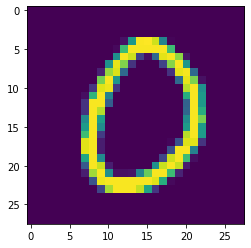

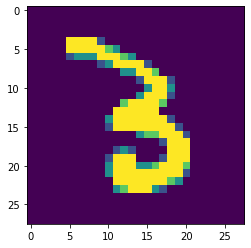

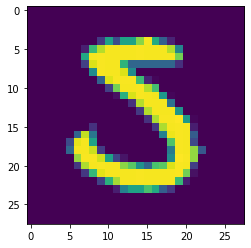

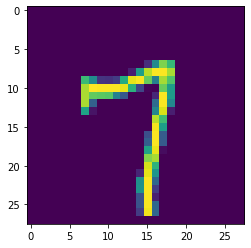

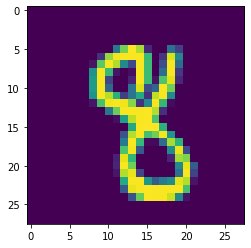

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
dataset = get_dataset("seq-mnist", 256, True)
data_loaders = []
for i in range(5):
  data_loaders.append(dataset.get_data_loaders())
for i in range(5):
  imgplot = plt.imshow(data_loaders[i][0].dataset[0][0].squeeze_(0))
  plt.show()

# data_loaders[num_task][0 --> train, 1 --> test].dataset[campione][0 --> img, 1 --> label]

In [10]:
# models/utils/continual_model.py

import torch.nn as nn
from torch.optim import SGD
import torch
import torchvision

class ContinualModel(nn.Module):
    """
    Continual learning model.
    """
    NAME = None
    COMPATIBILITY = []

    def __init__(self, backbone: nn.Module, loss: nn.Module,
                lr: float, buffer_size: int, minibatch_size: int, alpha: float, beta: float, transform: torchvision.transforms) -> None:
        super(ContinualModel, self).__init__()

        self.net = backbone
        self.loss = loss
        self.lr = lr
        self.buffer_size = buffer_size
        self.minibatch_size = minibatch_size
        self.alpha = alpha
        self.beta = beta
        self.transform = transform
        self.opt = SGD(self.net.parameters(), lr=self.lr)
        self.device = get_device()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Computes a forward pass.
        :param x: batch of inputs
        :param task_label: some models require the task label
        :return: the result of the computation
        """
        return self.net(x)

    def observe(self, inputs: torch.Tensor, labels: torch.Tensor,
                not_aug_inputs: torch.Tensor) -> float:
        """
        Compute a training step over a given batch of examples.
        :param inputs: batch of examples
        :param labels: ground-truth labels
        :param kwargs: some methods could require additional parameters
        :return: the value of the loss function
        """
        pass

In [11]:
# models/sgd.py

class Sgd(ContinualModel):
    NAME = 'sgd'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Sgd, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        print(self.net)

    def observe(self, inputs, labels, not_aug_inputs, cluster_labels, lambda_par):
        """
        lambda_par: regularization parameter for the loss function
        """
        self.opt.zero_grad()
        out1, out2 = self.net(inputs)
        loss1 = self.loss(out1, labels)
        loss2 = self.loss(out2, cluster_labels)
        loss = loss1 + (lambda_par * loss2)
        loss.backward()
        self.opt.step()

        return loss.item()

In [12]:
# models/__init__.py

import os
import importlib

models = ["sgd.py"]

def get_all_models():
    return [model.split('.')[0] for model in models
            if not model.find('__') > -1 and 'py' in model]

def get_model(model, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
    return model(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)

In [13]:
# utils/status.py

from datetime import datetime
import sys
import os
from typing import Any, Dict, Union
from torch import nn

def progress_bar(i: int, max_iter: int, epoch: Union[int, str],
                 task_number: int, loss: float) -> None:
    """
    Prints out the progress bar on the stderr file.
    :param i: the current iteration
    :param max_iter: the maximum number of iteration
    :param epoch: the epoch
    :param task_number: the task index
    :param loss: the current value of the loss function
    """
    if not (i + 1) % 10 or (i + 1) == max_iter:
        progress = min(float((i + 1) / max_iter), 1)
        progress_bar = ('█' * int(50 * progress)) + ('┈' * (50 - int(50 * progress)))
        print('\r[ {} ] Task {} | epoch {}: |{}| loss: {}'.format(
            datetime.now().strftime("%m-%d | %H:%M"),
            task_number + 1 if isinstance(task_number, int) else task_number,
            epoch,
            progress_bar,
            round(loss, 8)
        ), file=sys.stderr, end='', flush=True)

def progress_bar_clustering(i: int, max_iter: int, epoch: Union[int, str],
                 task_number: int, loss: float, loss_classification: float, loss_clustering: float) -> None:
    """
    Prints out the progress bar on the stderr file.
    :param i: the current iteration
    :param max_iter: the maximum number of iteration
    :param epoch: the epoch
    :param task_number: the task index
    :param loss: the current value of the loss function
    """
    if not (i + 1) % 10 or (i + 1) == max_iter:
        progress = min(float((i + 1) / max_iter), 1)
        progress_bar = ('█' * int(50 * progress)) + ('┈' * (50 - int(50 * progress)))
        print('\r[ {} ] Task {} | epoch {}: |{}| total loss: {} | classification loss: {} | clustering loss: {}'.format(
            datetime.now().strftime("%m-%d | %H:%M"),
            task_number + 1 if isinstance(task_number, int) else task_number,
            epoch,
            progress_bar,
            round(loss, 8),
            round(loss_classification, 8),
            round(loss_clustering, 8)
        ), file=sys.stderr, end='', flush=True)

In [14]:
# utils/loggers.py
import os
import sys
import numpy as np

def print_mean_accuracy(mean_acc: np.ndarray, task_number: int,
                        setting: str) -> None:
    """
    Prints the mean accuracy on stderr.
    :param mean_acc: mean accuracy value
    :param task_number: task index
    :param setting: the setting of the benchmark
    """
    if setting == 'domain-il':
        mean_acc, _ = mean_acc
        print('\nAccuracy for {} task(s): {} %'.format(
            task_number, round(mean_acc, 2)), file=sys.stderr)
    else:
        mean_acc_class_il, mean_acc_task_il = mean_acc
        print('\nAccuracy for {} task(s): \t [Class-IL]: {} %'
              ' \t [Task-IL]: {} %\n'.format(task_number, round(
            mean_acc_class_il, 2), round(mean_acc_task_il, 2)), file=sys.stderr)
        
def print_mean_accuracy_clustering(mean_acc: np.ndarray, clustering_acc: float, task_number: int,
                        setting: str) -> None:
    """
    Prints the mean accuracy on stderr.
    :param mean_acc: mean accuracy value
    :param task_number: task index
    :param setting: the setting of the benchmark
    """
    if setting == 'domain-il':
        mean_acc, _ = mean_acc
        print('\nAccuracy for {} task(s): {} %'.format(
            task_number, round(mean_acc, 2)), file=sys.stderr)
    else:
        mean_acc_class_il, mean_acc_task_il = mean_acc
        print('\nAccuracy for {} task(s): \t [Class-IL]: {} %'
              ' \t [Task-IL]: {} % \t [Clustering]: {} %\n'.format(task_number, round(
            mean_acc_class_il, 2), round(mean_acc_task_il, 2), round(clustering_acc, 2)), file=sys.stderr)
        
def print_mean_accuracy_clustering_only(mean_acc: np.ndarray, clustering_acc: float, task_number: int,
                        setting: str) -> None:
    """
    Prints the mean accuracy on stderr.
    :param mean_acc: mean accuracy value
    :param task_number: task index
    :param setting: the setting of the benchmark
    """
    if setting == 'domain-il':
        mean_acc, _ = mean_acc
        print('\nAccuracy for {} task(s): {} %'.format(
            task_number, round(mean_acc, 2)), file=sys.stderr)
    else:
        mean_acc_class_il = mean_acc
        print('\nAccuracy for {} task(s): \t [Class-IL]: {} %'
              ' \t [Task-IL]: {} %\n'.format(task_number, round(
            mean_acc_class_il.item(), 2), round(clustering_acc, 2)), file=sys.stderr)

# Clustering MNIST

In [15]:
from sklearn.cluster import MiniBatchKMeans

def K_means_cluster(n_clusters, data):
  # Initialize KMeans model
  kmeans = MiniBatchKMeans(n_clusters = n_clusters)

  # Fit the model to the training data
  labels = kmeans.fit_predict(data)
  return labels, kmeans.cluster_centers_

In [16]:
from torch.utils.data import TensorDataset, DataLoader

# Questa funzione effettua il clustering per ogni partizione/task di MNIST
# e ritorna i dataloader di train e test insieme alle cluster label trovate

def get_dataloaders_clustering(train_loader, test_loader, num_cluster, batch_size):
  input_train = torch.Tensor()
  label_train = torch.Tensor()
  not_aug_input_train = torch.Tensor()
  input_test = torch.Tensor()
  label_test = torch.Tensor()
  for i, data in enumerate(train_loader):
    inputs, labels, not_aug_inputs = data
    input_train = torch.cat((input_train, inputs), 0)
    label_train = torch.cat((label_train, labels), 0)
    not_aug_input_train = torch.cat((not_aug_input_train, not_aug_inputs), 0)
  x_train = input_train
  y_train = label_train
  y_train = y_train.type(torch.int64)
  not_aug_x_train = not_aug_input_train
  for i, data in enumerate(test_loader):
    inputs, labels = data
    input_test = torch.cat((input_test, inputs), 0)
    label_test = torch.cat((label_test, labels), 0)
  x_test = input_test
  y_test = label_test
  y_test = y_test.type(torch.int64)

  input_train = input_train.squeeze_(1)
  input_train = input_train.reshape(len(input_train),-1)
  cluster_labels_train, centroids = K_means_cluster(num_cluster, input_train)
  cluster_labels_train = torch.from_numpy(cluster_labels_train)
  cluster_labels_train = cluster_labels_train.type(torch.int64)

  input_test = input_test.squeeze_(1)
  input_test = input_test.reshape(len(input_test),-1)
  cluster_labels_test, centroids = K_means_cluster(num_cluster, input_test)
  cluster_labels_test = torch.from_numpy(cluster_labels_test)
  cluster_labels_test = cluster_labels_test.type(torch.int64)

  my_dataset_train = TensorDataset(x_train, y_train, not_aug_x_train, cluster_labels_train)
  my_dataset_test = TensorDataset(x_test, y_test, cluster_labels_test)
  my_dataloader_train = DataLoader(my_dataset_train, batch_size, True) # create dataloader and shuffle data
  my_dataloader_test = DataLoader(my_dataset_test, batch_size, True)
  return my_dataloader_train, my_dataloader_test

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([11479, 784])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([10863, 784])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([10124, 784])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([10929, 784])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([10605, 784])


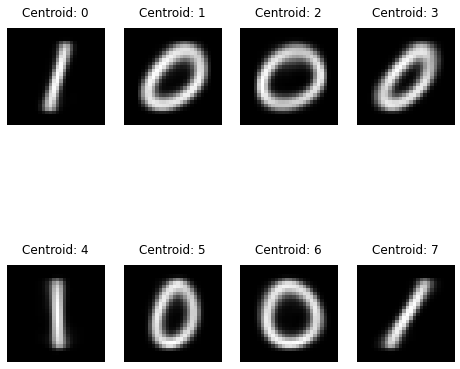

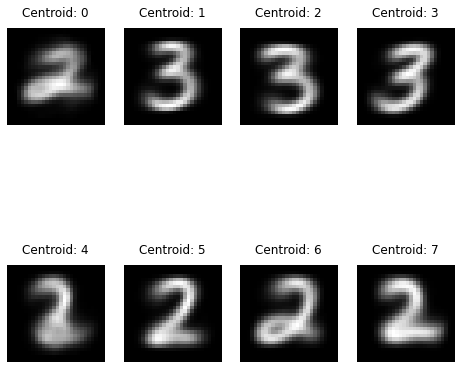

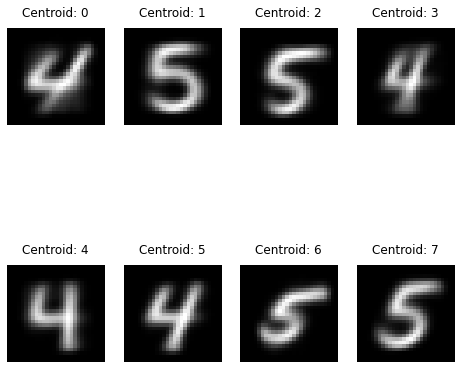

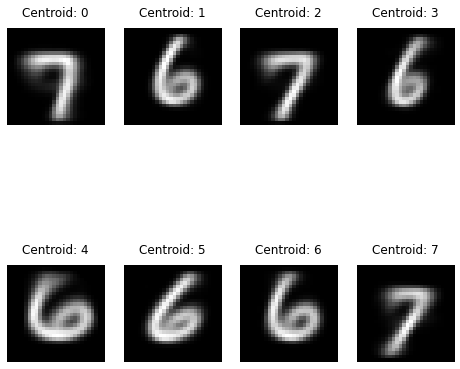

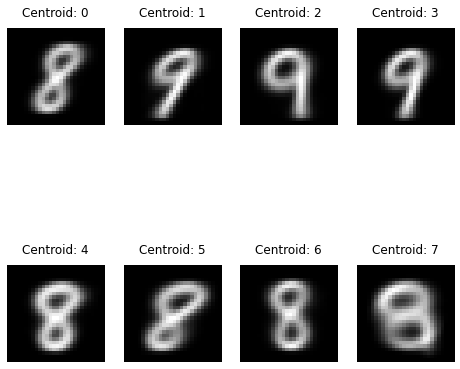

In [17]:
import matplotlib.pyplot as plt
# Visualizzazione qualitativa dei cluser
dataset = get_dataset("seq-mnist", 256, True)
num_cluster = 8
for t in range(dataset.N_TASKS):
  train_loader, test_loader = dataset.get_data_loaders()
  input = torch.Tensor()
  for i, data in enumerate(train_loader):
    inputs, labels, _ = data
    input = torch.cat((input, inputs), 0)

  input = input.squeeze_(1)
  input = input.reshape(len(input),-1)
  input = input.type(torch.FloatTensor) / 255.
  print(input.shape)
  cluster_labels, centroids = K_means_cluster(num_cluster, input)
  cluster_labels = torch.from_numpy(cluster_labels)
  cluster_labels = cluster_labels.type(torch.int64)

  # create figure with subplots using matplotlib.pyplot
  fig, axs = plt.subplots(2, 4, figsize = (8, 8))
  plt.gray()

  # loop through subplots and add centroid images
  for i, ax in enumerate(axs.flat):
      
      # determine inferred label using cluster_labels dictionary
      
      ax.set_title('Centroid: {}'.format(i))
      
      # add image to subplot
      ax.matshow((centroids[i] * 255).reshape(28, 28))
      ax.axis('off')
      
  # display the figure
  fig.show()

In [18]:
# Funzione per transformare i dati in input (Norm, Rotation, Flip, ...)
def transform_input(transform, data):
    inputs, labels, cluster_labels = data
    # Apply transformation
    transf_inputs = torch.Tensor()
    for j in range(inputs.shape[0]):
      input = inputs[j].permute(1, 2, 0)
      input = np.array(input)
      img = transform(input)
      img = img.permute(1, 2, 0)
      transf_inputs = torch.cat((transf_inputs, img))
    transf_inputs = transf_inputs.unsqueeze(0)
    transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
    transf_inputs = transf_inputs.permute(0, 3, 1, 2)
    transf_inputs = transf_inputs.float()
    labels = labels.long()
    cluster_labels = cluster_labels.long()
    labels = labels.squeeze(1)
    cluster_labels = cluster_labels.squeeze(1)
    return transf_inputs, labels, cluster_labels

In [19]:
# Funzione per il mapping dei parametri sul classificatore in continual
def update_weights(model, train_loader, num_cluster, c1, c2, normalize):
  test_transf = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2470, 0.2435, 0.2615))])
  status = model.net.training
  # Creo i tensori che conterranno i logits per i cluster
  logits_c1 = torch.empty(0)
  logits_c2 = torch.empty(0)
  logits_c1, logits_c2 = logits_c1.to(model.device), logits_c2.to(model.device)
  model.net.eval()
  # Scorro le immagini di training del task corrente
  for data in train_loader:
    transf_inputs, labels, cluster_labels = transform_input(test_transf, data)
    transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
    # Calcolo l'output del modello, rispettivamente per le classi in continual e per i cluster
    with torch.no_grad():
      outputs, cluster_outputs = model(transf_inputs)
    # Separo gli output della classe 1 da quelli della classe 2
    for i, lab in enumerate(labels):
      if(lab.item() == c1): # classe pari
        logits_c1 = torch.cat((logits_c1, cluster_outputs[i]), 0)
      else: # classe dispari
        logits_c2 = torch.cat((logits_c2, cluster_outputs[i]), 0)
  
  # Reshaping dei logit --> [num_campioni_classe, num_cluster]
  logits_c1 = logits_c1.view(int(len(logits_c1) / num_cluster), num_cluster)
  logits_c2 = logits_c2.view(int(len(logits_c2) / num_cluster), num_cluster)
  # Applico la funzione di softmax ai logits di output
  m = torch.nn.Softmax(dim=1)
  softmax_out_c1 = m(logits_c1)
  softmax_out_c2 = m(logits_c2)
  # Sommo i valori di ogni classe per tutti i campioni osservati
  softmax_sum_c1 = torch.sum(softmax_out_c1, 0)
  softmax_sum_c2 = torch.sum(softmax_out_c2, 0)
  # Ricavo l'indice del cluster che si attiva più frequentemente
  max_value1, cluster_index_c1 = torch.max(softmax_sum_c1, 0)
  max_value2, cluster_index_c2 = torch.max(softmax_sum_c2, 0)
  print("Indice del cluster più attivo per la classe 1: ", cluster_index_c1)
  print("Indice del cluster più attivo per la classe 2: ", cluster_index_c2)
  print("Norma dei pesi del classificatore per la classe 1 (prima):", torch.norm(model.net.classifier.weight[c1]).item())
  print("Norma dei pesi del classificatore per la classe 2 (prima):", torch.norm(model.net.classifier.weight[c2]).item())
  # Normalizzo i parametri prima di copiarli
  if normalize:
    with torch.no_grad():
      # Calcolo la norma dei pesi (del classificatore primario) relativi alle classi del task precedente
      # e ne faccio la media (sum / numero di classi viste fino a questo punto)
      sum_weights = 0
      sum_bias= 0
      for i in range(0, c1):
        sum_weights += torch.norm(model.net.classifier.weight[i]).item()
        sum_bias += torch.norm(model.net.classifier.bias[i]).item()
      weights_mean_norm = sum_weights / c1
      bias_mean_norm = sum_bias / c1
      # Aggiorno i pesi del classificatore primario con quelli del classificatore dei cluster,
      # con questi ultimi normalizzati rispetto alla media calcolata precedentemente
      weigths_norm_cl_1 = torch.norm(model.net.classifier_cluster.weight[cluster_index_c1]).item()
      weights_norm_cl_2 = torch.norm(model.net.classifier_cluster.weight[cluster_index_c2]).item()
      bias_norm_cl_1 = torch.norm(model.net.classifier_cluster.bias[cluster_index_c1]).item()
      bias_norm_cl_2 = torch.norm(model.net.classifier_cluster.bias[cluster_index_c2]).item()
      norm_weights_cl_1 = (model.net.classifier_cluster.weight[cluster_index_c1] / weigths_norm_cl_1) * weights_mean_norm
      norm_weights_cl_2 = (model.net.classifier_cluster.weight[cluster_index_c2] / weights_norm_cl_2) * weights_mean_norm
      norm_bias_cl_1 = (model.net.classifier_cluster.bias[cluster_index_c1] / bias_norm_cl_1) * bias_mean_norm
      norm_bias_cl_2 = (model.net.classifier_cluster.bias[cluster_index_c2] / bias_norm_cl_2) * bias_mean_norm
      model.net.classifier.weight[c1] = norm_weights_cl_1
      model.net.classifier.weight[c2] = norm_weights_cl_2
      model.net.classifier.bias[c1] = norm_bias_cl_1
      model.net.classifier.bias[c2] = norm_bias_cl_2
      #mean_c1 = torch.mean(model.net.classifier_cluster.weight[cluster_index_c1]).item()
      #mean_c2 = torch.mean(model.net.classifier_cluster.weight[cluster_index_c2]).item()
      #std_c1 = torch.std(model.net.classifier_cluster.weight[cluster_index_c1]).item()
      #std_c2 = torch.std(model.net.classifier_cluster.weight[cluster_index_c2]).item()
  else:
    with torch.no_grad():
      # Aggiorno i parametri del classificatore primario con quelli del classificatore dei cluster,
      # senza prima normalizzare (copia diretta)
      model.net.classifier.weight[c1] = model.net.classifier_cluster.weight[cluster_index_c1].clone().detach()
      model.net.classifier.weight[c2] = model.net.classifier_cluster.weight[cluster_index_c2].clone().detach()
      model.net.classifier.bias[c1] = model.net.classifier_cluster.bias[cluster_index_c1].clone().detach()
      model.net.classifier.bias[c2] = model.net.classifier_cluster.bias[cluster_index_c2].clone().detach()
  print("Norma dei pesi del classificatore per la classe 1 (dopo):", torch.norm(model.net.classifier.weight[c1]).item())
  print("Norma dei pesi del classificatore per la classe 2 (dopo):", torch.norm(model.net.classifier.weight[c2]).item())
  # Resetto i parametri del classificatore dei cluster
  model.net.classifier_cluster.apply(xavier)
  model.net.train(status)

In [20]:
# utils/training.py

import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, last=False) -> Tuple[list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes, accs_clustering = [], [], []
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        correct_cluster, total_cluster = 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            labels = labels.type(torch.int64)
            inputs = torch.unsqueeze(inputs, 1)
            with torch.no_grad():
                if 'class-il' not in model.COMPATIBILITY:
                    outputs, cluster_outputs = model(inputs, k) # fornisco anche l'indice del task
                else:
                    outputs, cluster_outputs = model(inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

                _, pred = torch.max(outputs.data, 1) # label predette dal modello (batch di 256, tranne l'ultimo)
                correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
                total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
                
                if k == task:
                    _, pred_cluster = torch.max(cluster_outputs.data, 1) # label predette dal modello per la classificazione dei cluster
                    correct_cluster += torch.sum(pred_cluster == cluster_labels).item() # calcolo il numero di predizioni corrette per il clustering
                    total_cluster += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il clustering
                    # Calcolo l'accuratezza per il clustering
                    clustering_acc = (correct_cluster / total_cluster * 100)

                if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                    mask_classes(outputs, dataset, k) # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                    _, pred = torch.max(outputs.data, 1)
                    correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes, clustering_acc


def train(model: ContinualModel, dataset: ContinualDataset, n_epochs: int, n_clusters: int, lambda_par: float, checkpoint_epoch: int, task: int, save: bool) -> None:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes, results_clustering = [], [], []
    accuracy = []
    loss_classification, loss_clustering = [], []
    test_loaders = list()
    checkpoint_epoch_passed = checkpoint_epoch

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = dataset.get_data_loaders()
        # Clustering with K-means
        train_loader, test_loader = get_dataloaders_clustering(train_loader, test_loader, n_clusters, dataset.batch_size)
        test_loaders.append(test_loader)
        if t:
            accs = evaluate(model, dataset, test_loaders, t, last=True)
            results[t-1] = results[t-1] + accs[0]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

            # Identificare i 2 cluster che si attivano maggiormente in corrispondenza delle 2 classi del nuovo task
            # e aggiornare i pesi del classificatore in CL
            #update_weights(model, train_loader, n_clusters, t+t, t+t+1, True)
            model.net.classifier_cluster.apply(xavier)

        if task is not None and t < task:
          # Load parameters
          weights_directory = "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            sum_clustering_loss = 0
            for i, data in enumerate(train_loader):
                inputs, labels, not_aug_inputs, cluster_labels = data
                inputs, labels = inputs.to(model.device), labels.to(
                    model.device)
                not_aug_inputs = not_aug_inputs.to(model.device)
                cluster_labels = cluster_labels.to(model.device)
                labels = labels.type(torch.int64)
                inputs = torch.unsqueeze(inputs, 1)
                total_loss, classification_loss, clustering_loss = model.observe(inputs, labels, not_aug_inputs, cluster_labels, lambda_par)
                sum_classification_loss += classification_loss
                sum_clustering_loss += clustering_loss
                #progress_bar(i, len(train_loader), epoch, t, loss)
                progress_bar_clustering(i, len(train_loader), epoch, t, total_loss, classification_loss, clustering_loss)
                # Save parameters every 10 epochs
                if(save and (epoch == 4)):
                  torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (epoch, t))

            loss_classification.append(sum_classification_loss / len(train_loader))
            loss_clustering.append(sum_clustering_loss / len(train_loader))
        accs = evaluate(model, dataset, test_loaders, t) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        clustering_acc = accs[2]
        accs = accs[0:2]
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task)
        accuracy.append(mean_acc)
        #print_mean_accuracy(mean_acc, t + 1, dataset.SETTING)
        print_mean_accuracy_clustering(mean_acc, clustering_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy', 'Clustering accuracy'))
    
    # Plotting delle loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Losses over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, loss_clustering)
    plt.legend(loc="upper right")
    plt.gca().legend(('Classification loss','Clustering loss'))
    return results, results_mask_classes, results_clustering

In [ ]:
# Train on MNIST using SGD
n_cluster = 6
dataset = get_dataset("seq-mnist", 10, True)
model = get_model(Sgd, backbone=dataset.get_backbone_cluster(n_cluster), loss=dataset.get_loss(), lr=0.03, buffer_size=None, minibatch_size=None, alpha=None, beta=None, transform=dataset.get_transform())
train(model, dataset, 1, n_cluster, 0.4, 0, None, False)

# CIFAR-10

In [23]:
# ResNet18.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, avg_pool2d
from typing import List
from typing import Tuple


def conv3x3(in_planes: int, out_planes: int, stride: int=1) -> F.conv2d:
    """
    Instantiates a 3x3 convolutional layer with no bias.
    :param in_planes: number of input channels
    :param out_planes: number of output channels
    :param stride: stride of the convolution
    :return: convolutional layer
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    """
    The basic block of ResNet.
    """
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int=1) -> None:
        """
        Instantiates the basic block of the network.
        :param in_planes: the number of input channels
        :param planes: the number of channels (to be possibly expanded)
        """
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (10)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    """
    ResNet network architecture. Designed for complex datasets.
    """

    def __init__(self, block: BasicBlock, num_blocks: List[int],
                 num_classes: int, num_clusters: int, nf: int) -> None:
        """
        Instantiates the layers of the network.
        :param block: the basic ResNet block
        :param num_blocks: the number of blocks per layer
        :param num_classes: the number of output classes
        :param nf: the number of filters
        """
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.block = block
        self.num_classes = num_classes
        self.nf = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)
        self.linear_cluster = nn.Linear(nf * 8 * block.expansion, num_clusters)

        self._features = nn.Sequential(self.conv1,
                                       self.bn1,
                                       nn.ReLU(),
                                       self.layer1,
                                       self.layer2,
                                       self.layer3,
                                       self.layer4
                                       )
        self.classifier = self.linear
        self.classifier_cluster = self.linear_cluster

    def _make_layer(self, block: BasicBlock, planes: int,
                    num_blocks: int, stride: int) -> nn.Module:
        """
        Instantiates a ResNet layer.
        :param block: ResNet basic block
        :param planes: channels across the network
        :param num_blocks: number of blocks
        :param stride: stride
        :return: ResNet layer
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (output_classes)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)  # 64, 32, 32
        out = self.layer2(out)  # 128, 16, 16
        out = self.layer3(out)  # 256, 8, 8
        out = self.layer4(out)  # 512, 4, 4
        out = avg_pool2d(out, out.shape[2]) # 512, 1, 1
        out = out.view(out.size(0), -1)  # 512
        out1 = self.classifier(out)
        out2 = self.classifier_cluster(out)
        return out1, out2

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (??)
        """
        out = self._features(x)
        out = avg_pool2d(out, out.shape[2])
        feat = out.view(out.size(0), -1)
        return feat

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (??)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (??)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (??)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)


def resnet18(nclasses: int, nclusters: int, nf: int=64) -> ResNet:
    """
    Instantiates a ResNet18 network.
    :param nclasses: number of output classes
    :param nf: number of filters
    :return: ResNet network
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nclusters, nf)

In [24]:
# denormalization.py

class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [25]:
# seq_cifar10.py

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from typing import Tuple

class MyCIFAR10(CIFAR10):
    """
    Overrides the CIFAR10 dataset to change the getitem function.
    """
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False) -> None:
        self.not_aug_transform = transforms.Compose([transforms.ToTensor()])
        super(MyCIFAR10, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index: int) -> Tuple[type(Image), int, type(Image)]:
        """
        Gets the requested element from the dataset.
        :param index: index of the element to be returned
        :returns: tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # to return a PIL Image
        img = Image.fromarray(img, mode='RGB')
        original_img = img.copy()

        not_aug_img = self.not_aug_transform(original_img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if hasattr(self, 'logits'):
            return img, target, not_aug_img, self.logits[index]

        return img, target, not_aug_img


class SequentialCIFAR10(ContinualDataset):

    NAME = 'seq-cifar10'
    SETTING = 'class-il'
    N_CLASSES_PER_TASK = 2
    N_TASKS = 5
    TRANSFORM = transforms.Compose(
            [transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    #TRANSFORM = transforms.Compose([transforms.ToTensor()])                       

    def get_data_loaders(self):
        transform = self.TRANSFORM

        test_transform = transforms.Compose(
            [transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        if self.validation:
            train_dataset, test_dataset = get_train_val(train_dataset,
                                                    test_transform, self.NAME)
        else:
            test_dataset = CIFAR10(base_path() + 'CIFAR10',train=False,
                                   download=True, transform=test_transform)

        train, test = store_masked_loaders(train_dataset, test_dataset, self)
        return train, test

    def not_aug_dataloader(self, batch_size):
        transform = transforms.Compose([transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        train_loader = get_previous_train_loader(train_dataset, batch_size, self)

        return train_loader

    @staticmethod
    def get_transform():
        transform = transforms.Compose(
            [transforms.ToPILImage(), SequentialCIFAR10.TRANSFORM])
        return transform

    @staticmethod
    def get_backbone():
        return resnet18(SequentialCIFAR10.N_CLASSES_PER_TASK
                        * SequentialCIFAR10.N_TASKS)
        
    @staticmethod
    def get_backbone_cluster(nclusters: int):
        return resnet18(SequentialCIFAR10.N_CLASSES_PER_TASK
                        * SequentialCIFAR10.N_TASKS, nclusters)
     
    @staticmethod
    def get_backbone_cluster_only(nclusters: int):
        return resnet18(nclusters, 0)

    @staticmethod
    def get_loss():
        return F.cross_entropy

    @staticmethod
    def get_normalization_transform():
        transform = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2470, 0.2435, 0.2615))
        return transform

    @staticmethod
    def get_denormalization_transform():
        transform = DeNormalize((0.4914, 0.4822, 0.4465),
                                (0.2470, 0.2435, 0.2615))
        return transform

In [26]:
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


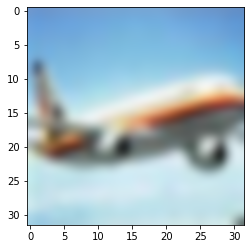

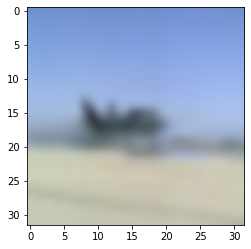

Files already downloaded and verified


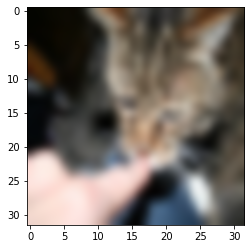

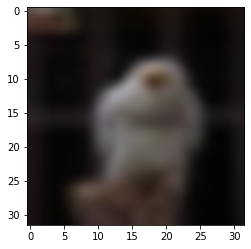

Files already downloaded and verified


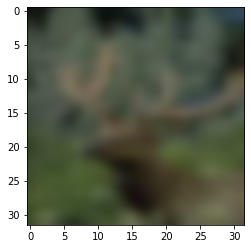

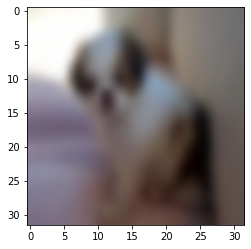

Files already downloaded and verified


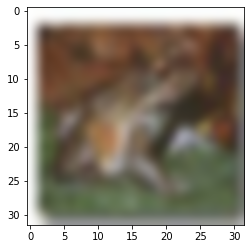

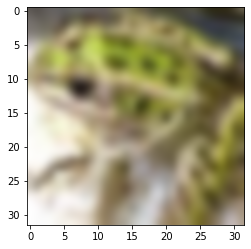

Files already downloaded and verified


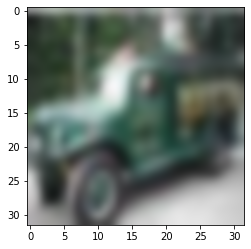

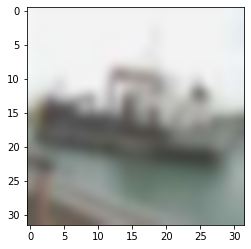

In [27]:
# Show images
import torchvision.transforms.transforms as transforms
import matplotlib.pyplot as plt
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
dataset_cifar = get_dataset("seq-cifar10", 256, True)
for i in range(dataset_cifar.N_TASKS):
  train_loader, test_loader, = dataset_cifar.get_data_loaders()
  for j in range(dataset_cifar.N_CLASSES_PER_TASK):
    img = train_loader.dataset[j][2].permute(1, 2, 0) # Get the non aug image
    plt.imshow(img, interpolation="bicubic")
    plt.show()

# Semantic Image Clustering (SCAN)

In [ ]:
!pip install tensorflow-addons
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Prepare the data
num_classes = 10
input_shape = (32, 32, 3)
x_train = [0, 0, 0, 0, 0]
y_train = [0, 0, 0, 0, 0]
x_test= [0, 0, 0, 0, 0]
y_test= [0, 0, 0, 0, 0]
x_data= [0, 0, 0, 0, 0]
y_data= [0, 0, 0, 0, 0]
len_x = 0
len_y = 0

dataset_cifar = get_dataset("seq-cifar10", 256, True)
for i in range(dataset_cifar.N_TASKS):
  train_loader, test_loader, = dataset_cifar.get_data_loaders()
  x_train[i] = train_loader.dataset.data
  y_train[i] = train_loader.dataset.targets
  y_train[i] = np.expand_dims(y_train[i], 1)
  x_test[i] = test_loader.dataset.data
  y_test[i] = test_loader.dataset.targets
  y_test[i] = np.expand_dims(y_test[i], 1)

  x_data[i] = np.concatenate([x_train[i], x_test[i]])
  y_data[i] = np.concatenate([y_train[i], y_test[i]])
  len_x += len(x_data[i])
  len_y += len(y_data[i])

print("x_data len:", len_x, "- y_data len:", len_y)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [ ]:
# Hyperparameters
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 10  # Number of clusters to be found.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [ ]:
# Implement data preprocessing as a sequential model with 2 layers
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size), # 32 x 32
        layers.Normalization(), # (input - mean) / sqrt(var)
    ]
)
# Compute the mean and the variance from the data for normalization.
for i in range(dataset_cifar.N_TASKS):
  data_preprocessing.layers[-1].adapt(x_data[i])

In [ ]:
# Data augmentation: model with 4 layers
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

In [ ]:
# Display a random image
for i in range(dataset_cifar.N_TASKS):
  image_idx = np.random.choice(range(x_data[i].shape[0]))
  image = x_data[i][image_idx]
  image_class = classes[y_data[i][image_idx][0]]
  plt.figure(figsize=(3, 3))
  plt.imshow(x_data[i][image_idx].astype("uint8"))
  plt.title(image_class)
  _ = plt.axis("off")

  # Display some augmented versions of the same image
  plt.figure(figsize=(10, 10))
  for i in range(9):
      augmented_images = data_augmentation(np.array([image]))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

# Representation learning: feature extraction using instance discrimination

In [ ]:
# Implement the vision encoder
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [   # Instantiate ResNet50 model without the fully-connected
            # layer on top of the net, random inizialiation for the weigths
            # and average pooling for feature extraction
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            # This layer implements the operation: output = dot(input, kernel) 
            # where input is represented by the "representation_dim" neurons, 
            # and kernel is a weights matrix created by the layer.
            layers.Dense(representation_dim),
        ]
    )
    return encoder

In [ ]:
# Implement the unsupervised contrastive loss
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss") # computes the weighted mean of the given values

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        # Logits are the product of the feature vectors, with the second transposed.
        # "temperature" is an hyperparameter and defines a scale for the dot-product similarity.
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1) # Compute the max across the axis 1
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # "targets" is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss between the labels and the predictions
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head --> output = z(g(x)).
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Clustering using KNN

In [ ]:
# Implement clustering consistency loss: this loss
# tries to make sure that neighbours have the same clustering assignments.
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity) # create a tensor with ones that has the same shape as the input
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss) # computes the mean across dimensions of the tensor

In [ ]:
# Implement the clusters entropy loss: this loss tries to make sure 
# that cluster distribution is roughly uniformed, to avoid assigning 
# most of the instances to one cluster.
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [ ]:
# Implement clustering model: this model takes a raw image as an input, 
# generates its feature vector using the trained encoder, and produces a 
# probability distribution of the clusters given the feature vector as the 
# cluster assignments.
def create_clustering_model(encoder, num_clusters, name=None):
    # Istantiate a tensor (32, 32, 3)
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [ ]:
# Implement clustering learner: this model receives the input anchor image and 
# its neighbours, produces the clusters assignments for them using the clustering_model, 
# and produces two outputs: 
# - 1) the similarity between the cluster assignments of the anchor image and its neighbours. 
#      This output is fed to the ClustersConsistencyLoss. 
# - 2) cluster assignments of the anchor images. This is fed to the ClustersEntropyLoss.
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [ ]:
# Compute clustering accuracy
# First, we assign a label for each cluster based on the majority label of its images. 
# Then, we compute the accuracy of each cluster by dividing the number of image with the 
# majority label by the size of the cluster.
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

# Training su CIFAR 10

In [ ]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)

In [ ]:
# Training encoder
def train_encoder(representation_learner, x_data, task, batch_size = 512, epochs = 200):
  # Create a a Cosine decay learning rate scheduler.
  lr_scheduler = keras.optimizers.schedules.CosineDecay(
      initial_learning_rate=0.001, decay_steps=500, alpha=0.1
  )
  # Compile the model (configure it for training).
  representation_learner.compile(
      optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
  )

  # Create a callback that saves the model's weights every 10 epochs
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath="/home/marco_palumbo/saved_models/Encoder_task{}/".format(task), 
      verbose=1, 
      save_weights_only=True,
      save_freq= 'epoch',
      period=10)
  
  # Load model (if it's the case)
  #representation_learner.load_weights("/home/marco_palumbo/saved_models/Encoder/")

  # Fit the model (train the model).
  history = representation_learner.fit(
      x=x_data,
      batch_size=batch_size,
      callbacks=[cp_callback],
      epochs=epochs,  # for better results, increase the number of epochs to 500.
  )
  #representation_learner.save
  return history

In [ ]:
# Train clustering learner
def train_clustering(encoder, x_data, task, batch_size = 500, epochs = 200):
  # Generate the embeddings for the images
  # Get the feature vector representations of the images.
  feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
  # Normalize the feature vectores.
  feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

  # Find the k nearest neighbours for each embedding
  neighbours = []
  num_batches = feature_vectors.shape[0] // batch_size
  for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])
  neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

  # If tune_encoder_during_clustering is set to False,
  # then freeze the encoder weights.
  for layer in encoder.layers:
      layer.trainable = tune_encoder_during_clustering
  # Create the clustering model and learner.
  clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
  clustering_learner = create_clustering_learner(clustering_model)
  # Instantiate the model losses.
  losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
  # Create the model inputs and labels.
  inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
  labels = tf.ones(shape=(x_data.shape[0]))
  # Compile the model.
  clustering_learner.compile(
      optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
      loss=losses,
  )
  # Create a callback that saves the model's weights every 10 epochs
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath="/home/marco_palumbo/saved_models/Clustering_Learner_{}_task_{}/".format(num_clusters, task), 
      verbose=1, 
      save_weights_only=True,
      save_freq='epoch',
      period=10)
  # Load model (if it's the case)
  #clustering_learner.load_weights("/home/marco_palumbo/saved_models/Clustering_Learner_{}/".format(num_clusters))
  # Begin training the model.
  history = clustering_learner.fit(x=inputs, y=labels, batch_size=512, callbacks=[cp_callback], epochs=epochs)
  return history, clustering_model

In [ ]:
# Save cluster labels up to the current task
import os
import sys
import pickle
file_name = "task_clusters.pkl"
open_file = open(file_name, "wb")
pickle.dump(task_clusters, open_file)
open_file.close()

In [ ]:
# Save dataset for each task
import os
import sys
import pickle
data_task_4 = list(zip(x_data[4], y_data[4]))
file_name = "data_task_4.pkl"
open_file = open(file_name, "wb")
pickle.dump(data_task_4, open_file)
open_file.close()

In [ ]:
# Load cluster labels
import os
import sys
import pickle
open_file = open("/content/drive/MyDrive/task_clusters.pkl", "rb")
task_clusters= pickle.load(open_file)
open_file.close()

print(type(task_clusters))

In [ ]:
# Train the entire SCAN model
task_clusters = list()
batch_size = 500
for i in range(dataset_cifar.N_TASKS):
  print("Train for task ", i)
  if i < 1: continue
  history = train_encoder(representation_learner, x_data[i], i)
  # Plot training loss
  plt.plot(history.history["loss"])
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.show()

  history, clustering_model = train_clustering(encoder, x_data[i], i)
  # Plot training loss
  plt.plot(history.history["loss"])
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.show()

  # Assign images to clusters
  # Get the cluster probability distribution of the input images.
  clustering_probs = clustering_model.predict(x_data[i], batch_size=batch_size, verbose=1)
  # Get the cluster of the highest probability.
  cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
  # Store the clustering confidence.
  # Images with the highest clustering confidence are considered the 'prototypes'
  # of the clusters.
  cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

  # Let's compute the cluster sizes
  # Notice that the clusters have roughly balanced sizes.
  clusters = defaultdict(list)
  for idx, c in enumerate(cluster_assignments):
      clusters[c].append((idx, cluster_confidence[idx]))
  
  # Aggiungo i cluster ricavati per il task corrente
  task_clusters.append(clusters)

  for c in range(num_clusters):
      print("cluster", c, ":", len(clusters[c]))

  # Visualize cluster images
  # Display the prototypes (instances with the highest clustering confidence) of each cluster:
  num_images = 8
  plt.figure(figsize=(15, 15))
  position = 1
  for c in range(num_clusters):
      cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

      for j in range(num_images):
          image_idx = cluster_instances[j][0]
          plt.subplot(num_clusters, num_images, position)
          plt.imshow(x_data[i][image_idx].astype("uint8"))
          plt.title(classes[y_data[i][image_idx][0]])
          plt.axis("off")
          position += 1

In [ ]:
# Assegna le label dei cluster alle immagini di ogni task
cluster_labels = list()
for i in range(dataset_cifar.N_TASKS):
  cluster_labels.append(torch.from_numpy(y_data[i]).clone().detach())

  for num_cluster in range(num_clusters):
    for j in range(len(task_clusters[i][num_cluster])):
      index = task_clusters[i][num_cluster][j][0]
      cluster_labels[i][index] = num_cluster

# Integra tutti i campioni in una lista aggiungendo le label dei cluster
data_with_cl = list(zip(x_data, y_data, cluster_labels))

In [ ]:
# data_with_cl[0][2][0]
# Primo indice --> task
# Secondo indice --> tensore (0 = x, 1 = y, 2 = cluster_lab)
# Terzo indice --> indice del campione

# Split into train and test set
num_samples_train = 8000
x_train = list()
y_train = list()
lab_train = list()
x_test = list()
y_test = list()
lab_test = list()
for i in range(dataset_cifar.N_TASKS):
  x_train.append(data_with_cl[i][0][: num_samples_train])
  y_train.append(data_with_cl[i][1][: num_samples_train])
  lab_train.append(data_with_cl[i][2][: num_samples_train])
  x_test.append(data_with_cl[i][0][num_samples_train:])
  y_test.append(data_with_cl[i][1][num_samples_train:])
  lab_test.append(data_with_cl[i][2][num_samples_train:])

# Zip train and test dataset
train_data = list(zip(x_train, y_train, lab_train))
test_data = list(zip(x_test, y_test, lab_test))

In [ ]:
# Import / Export dataset with cluster labels
import os
import sys
import pickle
#file_name_1 = "train_data200.pkl"
#file_name_2 = "test_data200.pkl"
#open_file = open(file_name_1, "wb")
#pickle.dump(train_data, open_file)
#open_file.close()
#open_file = open(file_name_2, "wb")
#pickle.dump(test_data, open_file)
#open_file.close()

train_path = "/home/marco_palumbo/data/train_data_multi_class.pkl"
test_path = "/home/marco_palumbo/data/test_data_multi_class.pkl"
open_file_1 = open(train_path, "rb")
open_file_2 = open(test_path, "rb")
train_data = pickle.load(open_file_1)
test_data = pickle.load(open_file_2)
open_file_1.close()
open_file_2.close()

print(train_data[0][0].shape)
print(train_data[0][2].max())

(8000, 32, 32, 3)
tensor(19)


In [ ]:
# train_data[indice_task][indice_item --> 0 = x, 1 = y, 2 = cluster_lab]
train_data[0][0].shape

In [ ]:
# Separate data for each cluster for plotting
task = 4
cluster = 0 # 6 clusters
mask = train_data[0][2].eq(cluster).squeeze(1)
masked_data = train_data[task][0][mask][:][:][:]

In [ ]:
# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(5, 5, figsize = (12, 12))

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # add image to subplot
    ax.matshow((masked_data[i]))
    ax.axis('off')
    
# display the figure
fig.show()

In [ ]:
# Test per verificare l'applicazione della 
# data augmentations alle immagini di CIFAR

transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
train_loader, test_loader = get_dataloaders(train_data[0], test_data[0], 256)
for i, data in enumerate(train_loader):
  inputs, labels, cluster_lab = data
  tensor = torch.Tensor()
  for j in range(inputs.shape[0]):
    input = inputs[j].permute(2, 1, 0)
    input = np.array(input)
    img = transf(input)
    img = img.permute(1, 2, 0)
    tensor = torch.cat((tensor, img))
  tensor = tensor.unsqueeze(0)
  tensor = tensor.reshape(inputs.shape[0], 32, 32, 3)
  tensor = tensor.permute(0, 3, 2, 1)
  print(tensor.shape)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(2,2,1)
# Plot original image
ax1.imshow(inputs[5].permute(2, 1, 0))
ax2 = fig.add_subplot(2,2,2)
# Plot transformed image
ax2.imshow(tensor[5].permute(2, 1, 0))
print(inputs[0].shape)
print(tensor[0].shape)

In [29]:
from torch.utils.data import TensorDataset, DataLoader

# Create data loaders for train and test data
def get_dataloaders(train_data: Tuple, test_data: Tuple, batch_size: int):
  train_x = torch.tensor(train_data[0])
  train_x = train_x.transpose(1, 3)
  train_x = train_x.transpose(2, 3)
  train_y = torch.tensor(train_data[1])
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
  test_x = torch.tensor(test_data[0])
  test_x = test_x.transpose(1, 3)
  test_x = test_x.transpose(2, 3)
  test_y = torch.tensor(test_data[1])
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
  # Separate data: 9000 for train, 1000 for test
  train_x = torch.cat((train_x, test_x[0:1000]))
  train_y = torch.cat((train_y, test_y[0:1000]))
  train_l = torch.cat((train_l, test_l[0:1000]))
  test_x = test_x[1000:2000]
  test_y = test_y[1000:2000]
  test_l = test_l[1000:2000]
  # Create loaders
  my_dataset_train = TensorDataset(train_x, train_y, train_l)
  my_dataset_test = TensorDataset(test_x, test_y, test_l)
  my_dataloader_train = DataLoader(my_dataset_train, batch_size, True) # create dataloader and shuffle data
  my_dataloader_test = DataLoader(my_dataset_test, batch_size, True)
  return my_dataloader_train, my_dataloader_test

In [30]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate_cifar(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, last=False) -> Tuple[list, list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes, accs_clustering = [], [], []
    test_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        correct_cluster, total_cluster = 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            # Apply test transformation
            transf_inputs = torch.Tensor()
            for j in range(inputs.shape[0]):
              input = inputs[j].permute(1, 2, 0)
              input = np.array(input)
              img = test_transf(input)
              img = img.permute(1, 2, 0)
              transf_inputs = torch.cat((transf_inputs, img))
            transf_inputs = transf_inputs.unsqueeze(0)
            transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
            transf_inputs = transf_inputs.permute(0, 3, 1, 2)
            transf_inputs = transf_inputs.float()
            labels = labels.long()
            cluster_labels = cluster_labels.long()
            labels = labels.squeeze(1)
            cluster_labels = cluster_labels.squeeze(1)
            transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs, cluster_outputs = model(transf_inputs, k) # fornisco anche l'indice del task
              else:
                  outputs, cluster_outputs = model(transf_inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

            _, pred = torch.max(outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
            
            if k == task:
                _, pred_cluster = torch.max(cluster_outputs.data, 1) # label predette dal modello per la classificazione dei cluster
                correct_cluster += torch.sum(pred_cluster == cluster_labels).item() # calcolo il numero di predizioni corrette per il clustering
                total_cluster += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il clustering
                # Calcolo l'accuratezza per il clustering
                clustering_acc = (correct_cluster / total_cluster * 100)

            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                mask_classes(outputs, dataset, k) # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

        
    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes, clustering_acc


def train_cifar(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, n_clusters: int, lambda_par: float, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes, results_clustering = [], [], []
    accuracy, cluster_accuracy = [], []
    loss_classification = []
    loss_clustering = []
    test_loaders = list()
    train_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    checkpoint_epoch_passed = checkpoint_epoch

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
        test_loaders.append(test_loader)
        if t:
            accs = evaluate_cifar(model, dataset, test_loaders, t, last=True)
            results[t-1] = results[t-1] + accs[0]
            #results_clustering[t-1] = results_clustering[t-1] + accs[2]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

            # Identificare i 2 cluster che si attivano maggiormente in corrispondenza delle 2 classi del nuovo task
            # e aggiornare i pesi del classificatore in CL.
            update_weights(model, train_loader, n_clusters, t+t, t+t+1, False)
            #model.net.classifier_cluster.apply(xavier)

        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering_new/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49 + 1
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering_new/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed + 1
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            sum_clustering_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, cluster_lab = data
                  # Apply train transformation
                  transf_inputs = torch.Tensor()
                  for j in range(inputs.shape[0]):
                    input = inputs[j].permute(1, 2, 0)
                    input = np.array(input)
                    img = train_transf(input)
                    img = img.permute(1, 2, 0)
                    transf_inputs = torch.cat((transf_inputs, img))
                  transf_inputs = transf_inputs.unsqueeze(0)
                  transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
                  transf_inputs = transf_inputs.permute(0, 3, 1, 2)
                  transf_inputs = transf_inputs.float()
                  labels = labels.long()
                  cluster_lab = cluster_lab.long()
                  labels = labels.squeeze(1)
                  cluster_lab = cluster_lab.squeeze(1)
                  transf_inputs, labels = transf_inputs.to(model.device), labels.to(
                      model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  inputs = inputs / 255
                  total_loss, classification_loss, clustering_loss = model.observe(transf_inputs, labels, inputs, cluster_lab, lambda_par)
                  sum_classification_loss += classification_loss
                  sum_clustering_loss += clustering_loss
                  #progress_bar(i, len(train_loader), epoch, t, loss)
                  progress_bar_clustering(i, len(train_loader), epoch, t, total_loss, classification_loss, clustering_loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_cifar_clustering_new/model_%d_epoch_%d_task.pt" % (epoch, t))
            loss_classification.append(sum_classification_loss / len(train_loader))
            loss_clustering.append(sum_clustering_loss / len(train_loader))
        accs = evaluate_cifar(model, dataset, test_loaders, t) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        #results_clustering.append(accs[2]) # accuratezza per il clustering
        clustering_acc = accs[2]
        accs = accs[0:2]
        print(accs)
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task) per i 2 scenari ed il clustering
        accuracy.append(mean_acc)
        cluster_accuracy.append(clustering_acc)
        #print_mean_accuracy(mean_acc, t + 1, dataset.SETTING)
        print_mean_accuracy_clustering(mean_acc, clustering_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy, cluster_accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy', 'Clustering Accuracy'))
    
    # Plotting delle loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Losses over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, loss_clustering)
    plt.legend(loc="upper right")
    plt.gca().legend(('Classification loss','Clustering loss'))
    return results, results_mask_classes, results_clustering

In [ ]:
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
num_cluster = 6
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Sgd, backbone=dataset_cifar.get_backbone_cluster(num_cluster), loss=dataset_cifar.get_loss(), lr=0.1, buffer_size=None, minibatch_size=None, alpha=None, beta=None, transform=dataset_cifar.get_transform())
results, results_mask_classes, results_clustering = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_cluster, 0.4, None, None)

# Train with DER model

In [32]:
# utils/buffer.py

import torch
import numpy as np
from typing import Tuple
from torchvision import transforms


def reservoir(num_seen_examples: int, buffer_size: int) -> int:
    """
    Reservoir sampling algorithm.
    :param num_seen_examples: the number of seen examples
    :param buffer_size: the maximum buffer size
    :return: the target index if the current image is sampled, else -1
    """
    if num_seen_examples < buffer_size:
        return num_seen_examples

    rand = np.random.randint(0, num_seen_examples + 1)
    if rand < buffer_size:
        return rand
    else:
        return -1


def ring(num_seen_examples: int, buffer_portion_size: int, task: int) -> int:
    return num_seen_examples % buffer_portion_size + task * buffer_portion_size


class Buffer:
    """
    The memory buffer of rehearsal method.
    """
    def __init__(self, buffer_size, device, n_tasks=None, mode='reservoir'):
        assert mode in ['ring', 'reservoir']
        self.buffer_size = buffer_size
        self.device = device
        self.num_seen_examples = 0
        self.functional_index = eval(mode)
        if mode == 'ring':
            assert n_tasks is not None
            self.task_number = n_tasks
            self.buffer_portion_size = buffer_size // n_tasks
        self.attributes = ['examples', 'labels', 'logits', 'task_labels']

    def init_tensors(self, examples: torch.Tensor, labels: torch.Tensor,
                     logits: torch.Tensor, task_labels: torch.Tensor) -> None:
        """
        Initializes just the required tensors.
        :param examples: tensor containing the images
        :param labels: tensor containing the labels
        :param logits: tensor containing the outputs of the network
        :param task_labels: tensor containing the task labels
        """
        for attr_str in self.attributes:
            attr = eval(attr_str)
            if attr is not None and not hasattr(self, attr_str):
                typ = torch.int64 if attr_str.endswith('els') else torch.float32
                setattr(self, attr_str, torch.zeros((self.buffer_size,
                        *attr.shape[1:]), dtype=typ, device=self.device))

    def add_data(self, examples, labels=None, logits=None, task_labels=None):
        """
        Adds the data to the memory buffer according to the reservoir strategy.
        :param examples: tensor containing the images
        :param labels: tensor containing the labels
        :param logits: tensor containing the outputs of the network
        :param task_labels: tensor containing the task labels
        :return:
        """
        if not hasattr(self, 'examples'):
            self.init_tensors(examples, labels, logits, task_labels)

        for i in range(examples.shape[0]):
            index = reservoir(self.num_seen_examples, self.buffer_size)
            self.num_seen_examples += 1
            if index >= 0:
                self.examples[index] = examples[i].to(self.device)
                if labels is not None:
                    self.labels[index] = labels[i].to(self.device)
                if logits is not None:
                    self.logits[index] = logits[i].to(self.device)
                if task_labels is not None:
                    self.task_labels[index] = task_labels[i].to(self.device)

    def get_data(self, size: int, transform: transforms=None) -> Tuple:
        """
        Random samples a batch of size items.
        :param size: the number of requested items
        :param transform: the transformation to be applied (data augmentation)
        :return:
        """
        if size > min(self.num_seen_examples, self.examples.shape[0]):
            size = min(self.num_seen_examples, self.examples.shape[0])

        choice = np.random.choice(min(self.num_seen_examples, self.examples.shape[0]),
                                  size=size, replace=False)
        if transform is None: transform = lambda x: x
        ret_tuple = (torch.stack([transform(ee.cpu())
                            for ee in self.examples[choice]]).to(self.device),)
        for attr_str in self.attributes[1:]:
            if hasattr(self, attr_str):
                attr = getattr(self, attr_str)
                ret_tuple += (attr[choice],)

        return ret_tuple

    def is_empty(self) -> bool:
        """
        Returns true if the buffer is empty, false otherwise.
        """
        if self.num_seen_examples == 0:
            return True
        else:
            return False

    def get_all_data(self, transform: transforms=None) -> Tuple:
        """
        Return all the items in the memory buffer.
        :param transform: the transformation to be applied (data augmentation)
        :return: a tuple with all the items in the memory buffer
        """
        if transform is None: transform = lambda x: x
        ret_tuple = (torch.stack([transform(ee.cpu())
                            for ee in self.examples]).to(self.device),)
        for attr_str in self.attributes[1:]:
            if hasattr(self, attr_str):
                attr = getattr(self, attr_str)
                ret_tuple += (attr,)
        return ret_tuple

    def empty(self) -> None:
        """
        Set all the tensors to None.
        """
        for attr_str in self.attributes:
            if hasattr(self, attr_str):
                delattr(self, attr_str)
        self.num_seen_examples = 0

In [33]:
# models/der.py

from torch.nn import functional as F

class Der(ContinualModel):
    NAME = 'der'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Der, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs, cluster_labels, lambda_par):

        self.opt.zero_grad()

        out1, out2 = self.net(inputs)
        loss1 = self.loss(out1, labels)
        loss2 = self.loss(out2, cluster_labels)
        loss = loss1 + (lambda_par * loss2)

        if not self.buffer.is_empty():
            buf_inputs, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs, _ = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, logits=out1.data)

        return loss.item(), loss1.item(), loss2.item()

In [ ]:
# Train MNIST using DER
#for i in range(9):
num_cluster = 15
dataset = get_dataset("seq-mnist", 10, True)
model = get_model(Der, backbone=dataset.get_backbone_cluster(num_cluster), loss=dataset.get_loss(), lr=0.03, buffer_size=500, minibatch_size=128, alpha=1.0, beta=None, transform=dataset.get_transform())
results, results_mask_classes, results_clustering = train(model, dataset, 5, num_cluster, 1.0, 49, 4, False)

/tmp/ipykernel_8355/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_8355/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)


([99.6], [99.6])



Accuracy for 1 task(s): 	 [Class-IL]: 99.6 % 	 [Task-IL]: 99.6 % 	 [Clustering]: 0.3 %



Indice del cluster più attivo per la classe 1:  tensor(0, device='cuda:0')
Indice del cluster più attivo per la classe 2:  tensor(0, device='cuda:0')
Norma dei pesi del classificatore per la classe 1 (prima): 0.5073872804641724
Norma dei pesi del classificatore per la classe 2 (prima): 0.5023137927055359
Norma dei pesi del classificatore per la classe 1 (dopo): 1.651209831237793
Norma dei pesi del classificatore per la classe 2 (dopo): 1.651209831237793
([82.1, 95.7], [94.39999999999999, 98.0])



Accuracy for 2 task(s): 	 [Class-IL]: 88.9 % 	 [Task-IL]: 96.2 % 	 [Clustering]: 3.5 %



Indice del cluster più attivo per la classe 1:  tensor(0, device='cuda:0')
Indice del cluster più attivo per la classe 2:  tensor(3, device='cuda:0')
Norma dei pesi del classificatore per la classe 1 (prima): 0.5213131308555603
Norma dei pesi del classificatore per la classe 2 (prima): 0.5192603468894958
Norma dei pesi del classificatore per la classe 1 (dopo): 2.0037219524383545
Norma dei pesi del classificatore per la classe 2 (dopo): 1.8906030654907227
([83.7, 57.8, 87.0], [93.0, 89.3, 99.2])



Accuracy for 3 task(s): 	 [Class-IL]: 76.17 % 	 [Task-IL]: 93.83 % 	 [Clustering]: 0.0 %



Indice del cluster più attivo per la classe 1:  tensor(2, device='cuda:0')
Indice del cluster più attivo per la classe 2:  tensor(3, device='cuda:0')
Norma dei pesi del classificatore per la classe 1 (prima): 0.5131367444992065
Norma dei pesi del classificatore per la classe 2 (prima): 0.5454708337783813
Norma dei pesi del classificatore per la classe 1 (dopo): 2.4012222290039062
Norma dei pesi del classificatore per la classe 2 (dopo): 1.896924376487732
([6.1, 29.299999999999997, 48.5, 75.0], [69.19999999999999, 82.69999999999999, 88.1, 82.8])



Accuracy for 4 task(s): 	 [Class-IL]: 39.72 % 	 [Task-IL]: 80.7 % 	 [Clustering]: 0.0 %



Indice del cluster più attivo per la classe 1:  tensor(3, device='cuda:0')
Indice del cluster più attivo per la classe 2:  tensor(3, device='cuda:0')
Norma dei pesi del classificatore per la classe 1 (prima): 0.586390495300293
Norma dei pesi del classificatore per la classe 2 (prima): 0.6046144962310791
Norma dei pesi del classificatore per la classe 1 (dopo): 2.100196361541748
Norma dei pesi del classificatore per la classe 2 (dopo): 2.100196361541748



Accuracy for 5 task(s): 	 [Class-IL]: 55.96 % 	 [Task-IL]: 88.58 % 	 [Clustering]: 0.0 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([34.5, 35.9, 54.7, 67.2, 87.5], [84.6, 82.0, 91.0, 96.3, 89.0])


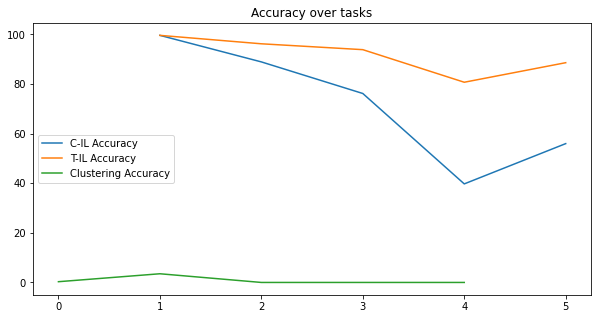

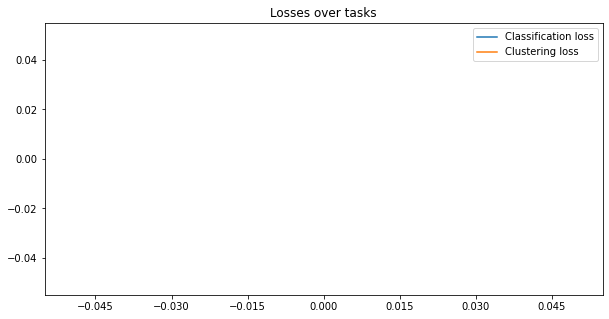

In [ ]:
# Train Cifar-10 using DER
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
num_cluster = 6
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Der, backbone=dataset_cifar.get_backbone_cluster(num_cluster), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=500, minibatch_size=32, alpha=0.3, beta=None, transform=dataset_cifar.get_transform())
results, results_mask_classes, results_clustering = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_cluster, 0.5, 49, 4, False)

# Valutazione degli scenari

Text(0.5, 1.0, 'Accuracy for C-IL task (MNIST)')

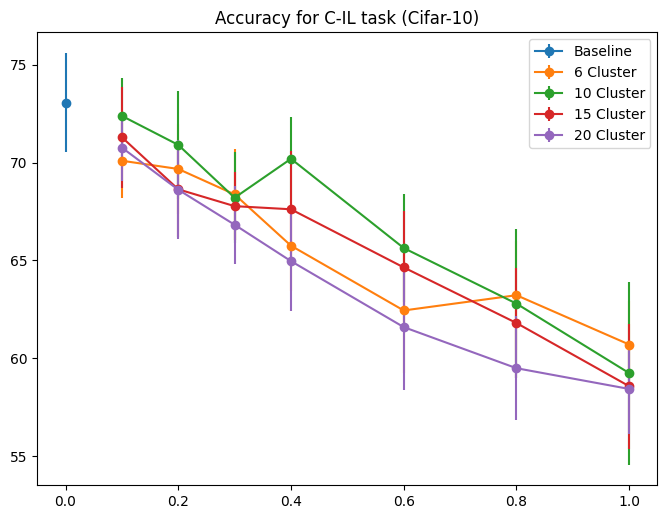

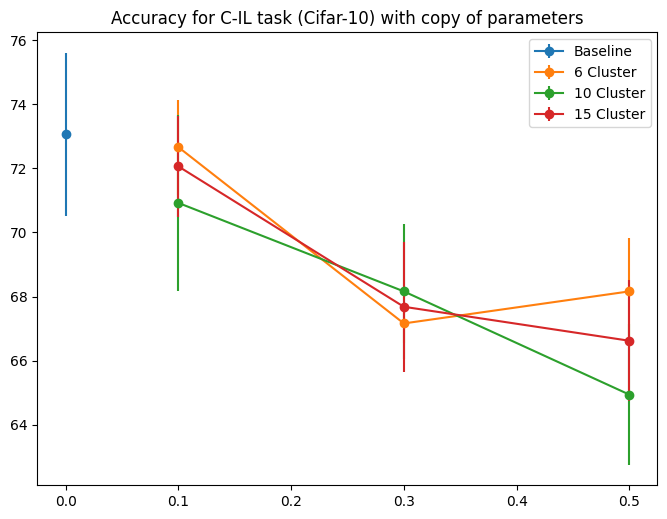

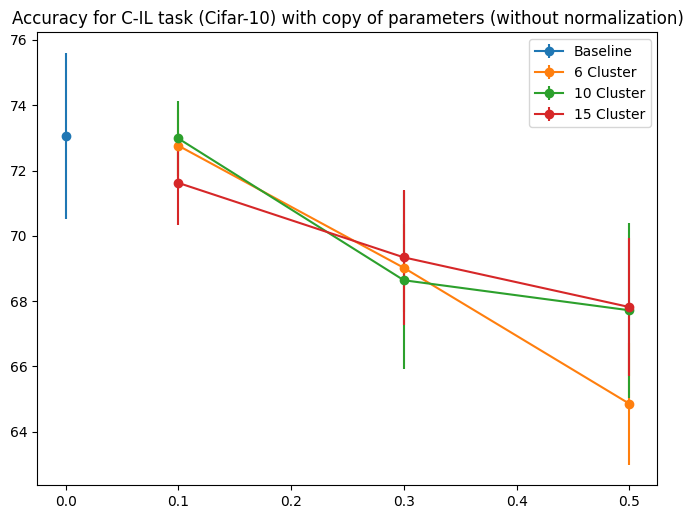

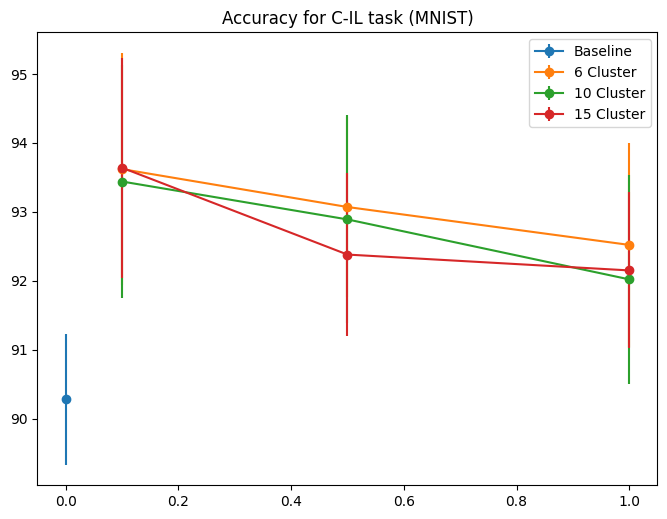

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torchvision
import statistics

# Accuratezze per il C-IL (Cifar-10)
results_baseline = [73.2, 76.1, 73.6, 77.2, 71.4, 68.1, 71.9, 71.7, 73.9, 73.5]
results_baseline_mean = statistics.mean(results_baseline)
results_baseline_std = statistics.stdev(results_baseline)
results_6 = [[67.2, 69.8, 70.7, 71.7, 67.3, 71.4, 68.4, 70.1, 72.9, 71.4], [68.7, 72.1, 65.7, 70.8, 70.4, 66.2, 72.6, 71.4, 69.6, 69.2], 
             [67.5, 68.7, 72.9, 65.4, 71.2, 68.8, 67.2, 67.4, 65.6, 69], [65.3, 66.1, 66.2, 63.5, 68.1, 70.6, 65.7, 62.3, 64.8, 64.9], 
             [62, 66.3, 61.7, 55.1, 64.4, 63.7, 65.4, 64, 60.3, 61.5], [57.3, 63.4, 61.8, 62.8, 65.1, 60.1, 65.5, 65.7, 65.5, 65], 
             [57.3, 61, 60, 61.5, 61.6, 57.3, 62.7, 60.6, 60.4, 64.6]]
results_6_mean = []
results_6_std = []
results_6_copy = [[70.8, 74, 74.1, 71.5, 72.9], [67.1, 68.2, 66.6, 67.1, 66.8], [65.7, 68.2, 70.1, 67.6, 69.2]]
results_6_copy_mean = []
results_6_copy_std = []
results_6_copy_no_norm = [[71.8, 71.6, 74.3, 73, 73.1], [69.2, 68.3, 67.3, 69.4, 70.9], [64, 62, 66.6, 66, 65.7]]
results_6_copy_no_norm_mean = []
results_6_copy_no_norm_std = []
results_10 = [[67.6, 71.9, 74.3, 73.7, 72.1, 72.9, 73.5, 73.5, 73, 71.3], [71.5, 74.3, 74.5, 71.9, 65.5, 71.9, 71, 68, 71.3, 69.1],
              [63.9, 67.4, 71.4, 68.6, 69.2, 69, 65.4, 68, 67.8, 71.3], [68.4, 67.6, 72.2, 74, 72.6, 69.1, 70.3, 70.1, 69.6, 68], 
              [66.4, 68.8, 67.8, 69.9, 63.9, 64, 66.8, 63, 61.3, 64.4], [60, 67.5, 69.2, 60.4, 59.6, 56.9, 63.5, 65.7, 61.9, 63.2], 
              [59.2, 65.9, 68.1, 53.2, 55.7, 57.3, 59.2, 58.6, 60.4, 54.8]]
results_10_mean = []
results_10_std = []
results_10_copy = [[69.2, 72.1, 74.9, 67.8, 70.6], [64.8, 68.7, 70.3, 67.7, 69.3], [63.6, 67.6, 64.5, 66.7, 62.3]]
results_10_copy_mean = []
results_10_copy_std = []
results_10_copy_no_norm = [[71.9, 73.5, 74.6, 71.9, 73], [64, 69.3, 68.7, 70.3, 70.9], [63.7, 70.5, 68.6, 69.3, 66.5]]
results_10_copy_no_norm_mean = []
results_10_copy_no_norm_std = []
results_15 = [[69.6, 72.9, 72.6, 73.9, 67.5, 66.7, 70.9, 73, 71.8, 74], [69.1, 63.2, 69.1, 67.7, 69.7, 66.2, 68.9, 71, 71.5, 69.9], 
              [66.1, 69.5, 68.2, 65.8, 66.2, 71.3, 67.8, 66.3, 68.4, 68.1], [63, 65.6, 68.6, 63.5, 69.3, 69.2, 66.8, 72.9, 68.2, 69], 
              [61.2, 59.7, 63.7, 65.6, 65.9, 61.9, 66.1, 66.9, 68.9, 66.5], [60.7, 65.7, 57.8, 64.7, 64.6, 63.9, 57.9, 61.2, 59.9, 61.6], 
              [56.5, 58.7, 57.8, 52.1, 57.9, 57, 62.9, 61.5, 58.9, 62.4]]
results_15_mean = []
results_15_std = []
results_15_copy = [[70.6, 70.9, 72.7, 74.5, 71.6], [66.3, 68.4, 68.3, 65.1, 70.3], [67.2, 65, 68.6, 68, 64.3]]
results_15_copy_mean = []
results_15_copy_std = []
results_15_copy_no_norm = [[71.9, 70.7, 73.6, 70.3, 71.6], [66.1, 69.3, 71.8, 70.1, 69.4], [65.7, 65.5, 69.7, 69.8, 68.4]]
results_15_copy_no_norm_mean = []
results_15_copy_no_norm_std = []
results_20 = [[69.6, 71, 70.4, 73.1, 68.3, 73.4, 68.8, 72, 71.2, 69.8], [66.3, 64.1, 65.9, 72, 70.3, 69.4, 67.9, 71, 68.9, 70.3], 
              [63.5, 66.5, 66, 67.2, 64.4, 70.7, 68.4, 67, 67.4, 67.1], [60.9, 65.5, 63.3, 66.8, 68.1, 66.8, 64.1, 68.5, 62.2, 63.4], 
              [56.7, 62.1, 58.8, 64.4, 65.9, 59.6, 60.7, 59.5, 61.6, 66.6], [55.6, 59.9, 57.9, 64.6, 57.3, 56.9, 60.3, 61.1, 59.6, 61.7], 
              [55.3, 60, 61.8, 59.1, 59.2, 55.2, 55.7, 60.7, 59.3, 58]]
results_20_mean = []
results_20_std = []
lambda_par = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
lambda_par_copy = [0.1, 0.3, 0.5]

# Accuratezze per il C-IL (MNIST)
results_baseline_mnist = [91.1, 90, 89.3, 90.4, 88.6, 89.6, 91.5, 91.5, 90.2, 90.6]
results_baseline_mnist_mean = statistics.mean(results_baseline_mnist)
results_baseline_mnist_std = statistics.stdev(results_baseline_mnist)
results_6_mnist = [[89.3, 92.6, 93.7, 93.6, 94, 94.2, 94.1, 94.6, 94.8, 95.3], [89.7, 93.1, 92.5, 93.3, 93, 93.4, 94.1, 93.4, 94.3, 93.9], 
                   [88.5, 91.9, 92.7, 93, 93.1, 93, 93.6, 93.1, 93.4, 92.9]]
results_6_mnist_mean = []
results_6_mnist_std = []
results_10_mnist = [[89, 92.8, 93.3, 93.6, 93.6, 94.6, 93.7, 94.6, 94.6, 94.6], [89, 91.7, 93.5, 93.2, 93.5, 93.1, 93.7, 93.7, 93.4, 94.1], 
                   [88.3, 91.1, 91.7, 92.4, 92.4, 91.7, 92.7, 93.1, 93.6, 93.2]]
results_10_mnist_mean = []
results_10_mnist_std = []
results_15_mnist = [[89.3, 93.4, 93.4, 94, 94.4, 94.4, 93.9, 94.5, 94.2, 94.9], [89.6, 92.4, 92.4, 91.1, 92.5, 93.1, 93.1, 92.9, 93.2, 93.5], 
                   [89.6, 91.1, 91.7, 92.5, 92.2, 92.4, 92.8, 92.7, 92.8, 93.7]]
results_15_mnist_mean = []
results_15_mnist_std = []
lambda_par_mnist = [0.1, 0.5, 1]

for i in range(len(results_6)):
  results_6_mean.append(statistics.mean(results_6[i]))
  results_6_std.append(statistics.stdev(results_6[i]))
    
for i in range(len(results_6_copy)):
  results_6_copy_mean.append(statistics.mean(results_6_copy[i]))
  results_6_copy_std.append(statistics.stdev(results_6_copy[i]))
    
for i in range(len(results_6_copy_no_norm)):
  results_6_copy_no_norm_mean.append(statistics.mean(results_6_copy_no_norm[i]))
  results_6_copy_no_norm_std.append(statistics.stdev(results_6_copy_no_norm[i]))

for i in range(len(results_10)):
  results_10_mean.append(statistics.mean(results_10[i]))
  results_10_std.append(statistics.stdev(results_10[i]))

for i in range(len(results_10_copy)):
  results_10_copy_mean.append(statistics.mean(results_10_copy[i]))
  results_10_copy_std.append(statistics.stdev(results_10_copy[i]))
    
for i in range(len(results_10_copy_no_norm)):
  results_10_copy_no_norm_mean.append(statistics.mean(results_10_copy_no_norm[i]))
  results_10_copy_no_norm_std.append(statistics.stdev(results_10_copy_no_norm[i])) 
    
for i in range(len(results_15)):
  results_15_mean.append(statistics.mean(results_15[i]))
  results_15_std.append(statistics.stdev(results_15[i]))
    
for i in range(len(results_15_copy)):
  results_15_copy_mean.append(statistics.mean(results_15_copy[i]))
  results_15_copy_std.append(statistics.stdev(results_15_copy[i]))
    
for i in range(len(results_15_copy_no_norm)):
  results_15_copy_no_norm_mean.append(statistics.mean(results_15_copy_no_norm[i]))
  results_15_copy_no_norm_std.append(statistics.stdev(results_15_copy_no_norm[i]))

for i in range(len(results_20)):
  results_20_mean.append(statistics.mean(results_20[i]))
  results_20_std.append(statistics.stdev(results_20[i]))
    
for i in range(len(results_6_mnist)):
  results_6_mnist_mean.append(statistics.mean(results_6_mnist[i]))
  results_6_mnist_std.append(statistics.stdev(results_6_mnist[i]))
    
for i in range(len(results_10_mnist)):
  results_10_mnist_mean.append(statistics.mean(results_10_mnist[i]))
  results_10_mnist_std.append(statistics.stdev(results_10_mnist[i]))
    
for i in range(len(results_15_mnist)):
  results_15_mnist_mean.append(statistics.mean(results_15_mnist[i]))
  results_15_mnist_std.append(statistics.stdev(results_15_mnist[i]))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par, results_6_mean, yerr=results_6_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par, results_10_mean, yerr=results_10_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par, results_15_mean, yerr=results_15_std, marker = "o", label='15 Cluster')
plt.errorbar(lambda_par, results_20_mean, yerr=results_20_std, marker = "o", label='20 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for C-IL task (Cifar-10)")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_copy, results_6_copy_mean, yerr=results_6_copy_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_copy, results_10_copy_mean, yerr=results_10_copy_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_copy, results_15_copy_mean, yerr=results_15_copy_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for C-IL task (Cifar-10) with copy of parameters")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_copy, results_6_copy_no_norm_mean, yerr=results_6_copy_no_norm_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_copy, results_10_copy_no_norm_mean, yerr=results_10_copy_no_norm_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_copy, results_15_copy_no_norm_mean, yerr=results_15_copy_no_norm_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for C-IL task (Cifar-10) with copy of parameters (without normalization)")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mnist_mean, yerr=results_baseline_mnist_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_mnist, results_6_mnist_mean, yerr=results_6_mnist_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_mnist, results_10_mnist_mean, yerr=results_10_mnist_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_mnist, results_15_mnist_mean, yerr=results_15_mnist_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for C-IL task (MNIST)")

Text(0.5, 1.0, 'Accuracy for T-IL task (MNIST)')

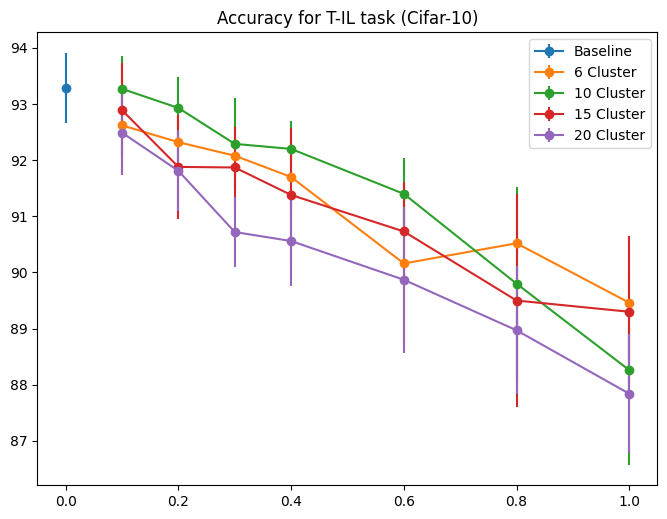

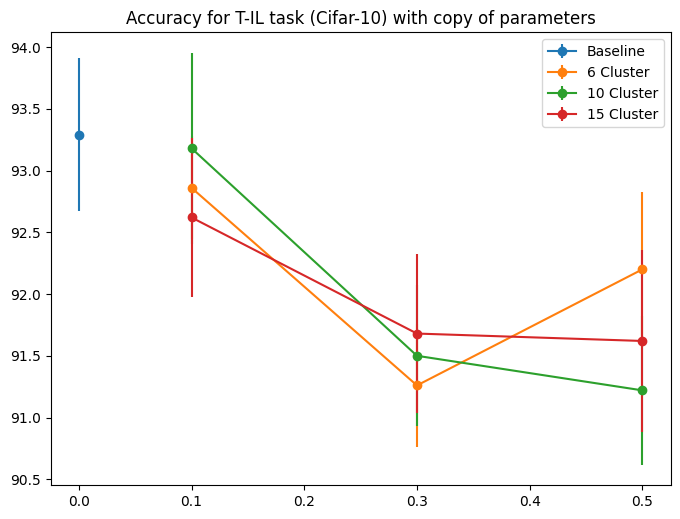

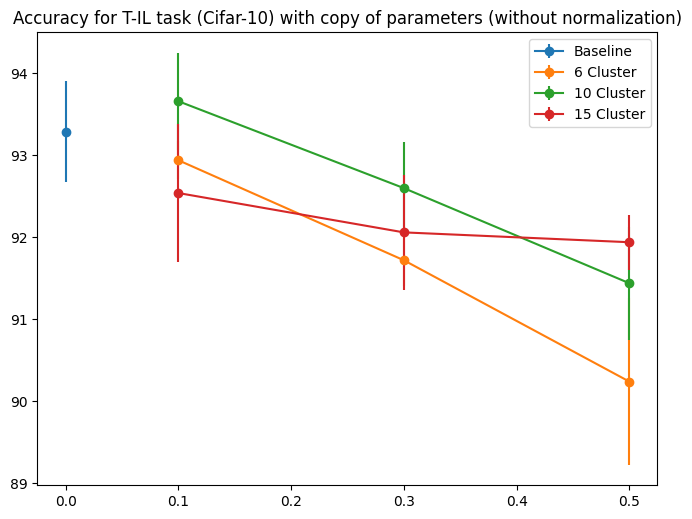

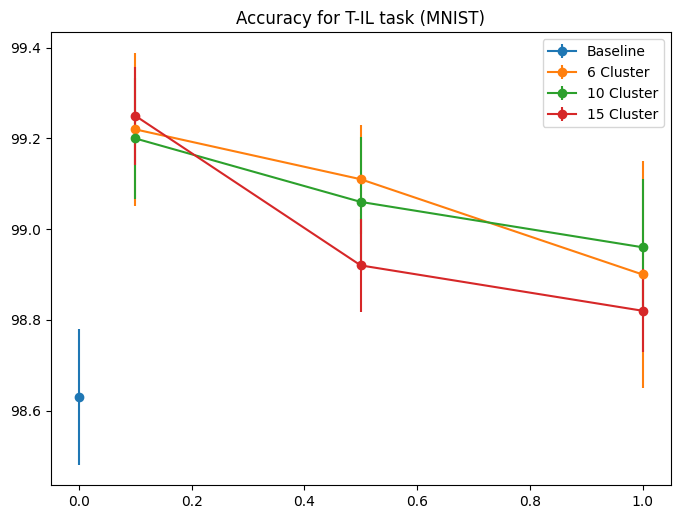

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torchvision
import statistics

# Accuratezze per il T-IL (relative solamente al 5° task)
results_baseline = [93.7, 94, 92.8, 94.1, 93.2, 92.2, 93.1, 93.6, 92.6, 93.6]
results_baseline_mean = statistics.mean(results_baseline)
results_baseline_std = statistics.stdev(results_baseline)
results_6 = [[91.9, 92.4, 93.3, 92.8, 90.6, 92.8, 92.4, 93.7, 93.4, 92.9], [91.7, 93, 92.4, 92.8, 92.5, 91.3, 92.9, 92.4, 91.4, 92.8], 
             [91.9, 92.5, 91.7, 91, 92.5, 91.9, 92.4, 92.9, 91.5, 92.5], [91.8, 92.8, 91.3, 90.8, 91.5, 92, 91.5, 90.8, 92, 92.5], 
             [90.2, 90.8, 90.4, 86.7, 91.6, 91.2, 90, 91, 89, 90.7], [89.5, 90.4, 89.8, 90.8, 90.6, 90.7, 90, 91.6, 91, 90.8], 
             [89.1, 88.4, 89.2, 91.1, 90.8, 87.8, 89.8, 89.2, 89.3, 89.9]]
results_6_mean = []
results_6_std = []
results_6_copy = [[92.4, 93.4, 92.9, 92.5, 93.1], [91, 91.2, 92.1, 91.2, 90.8], [92.5, 92, 92.5, 92.8, 91.2]]
results_6_copy_mean = []
results_6_copy_std = []
results_6_copy_no_norm = [[93.1, 93, 93.2, 92.7, 92.7], [91.9, 91.2, 91.7, 92, 91.8], [90.9, 88.6, 90.9, 90.9, 89.9]]
results_6_copy_no_norm_mean = []
results_6_copy_no_norm_std = []
results_10 = [[92.9, 92.7, 92.3, 93.2, 93.8, 93.5, 94, 93, 93.2, 94.1], [93.4, 93.6, 93.5, 93.1, 92.2, 92.8, 92.8, 92.1, 93.4, 92.4], 
              [91.3, 90.9, 92.9, 92.6, 92.4, 92.9, 92.4, 91.5, 92.4, 93.6], [92, 92.4, 92.4, 92.7, 92.9, 92, 91.7, 92.4, 92.3, 91.2], 
              [91.8, 91.7, 91, 92.6, 90.9, 90.3, 91.8, 91.3, 91.1, 91.5], [88, 91.4, 91.2, 89.3, 88.4, 86.3, 90.4, 90.9, 91.1, 91], 
              [88.7, 90.6, 90.9, 84.9, 87.5, 87.8, 87.7, 88.7, 88, 87.8]]
results_10_mean = []
results_10_std = []
results_10_copy = [[93, 93.3, 93.5, 92, 94.1], [90.7, 92, 91.9, 91.1, 91.8], [90.9, 92, 91.4, 91.4, 90.4]]
results_10_copy_mean = []
results_10_copy_std = []
results_10_copy_no_norm = [[93.7, 93.6, 94.6, 93, 93.4], [91.7, 93, 92.4, 92.9, 93], [90.4, 92.2, 91.4, 91.3, 91.9]]
results_10_copy_no_norm_mean = []
results_10_copy_no_norm_std = []
results_15 = [[93.1, 92.8, 93.2, 94, 92.8, 90.8, 93.4, 93.3, 92.9, 92.6], [92.7, 91.1, 92.5, 90, 92.8, 92.3, 91.1, 91.4, 92.5, 92.4], 
              [91, 91.9, 92.4, 91.5, 91.1, 93.4, 92, 91.9, 92.3, 91.2], [89.3, 90.3, 91.1, 90.4, 91.8, 93, 92.1, 93, 91.9, 90.9], 
              [89, 90.4, 90.4, 89.7, 91, 91.1, 92.1, 91.1, 91.3, 91.2], [90, 91.4, 85.3, 91.4, 91, 90.2, 88.7, 90.3, 87.8, 88.9], 
              [89.8, 89.8, 90.6, 87.7, 91.7, 87.2, 89.9, 88.5, 88.9, 88.9]]
results_15_mean = []
results_15_std = []
results_15_copy = [[91.6, 92.5, 93, 93.3, 92.7], [90.9, 92, 91.1, 92, 92.4], [92, 91.9, 90.9, 92.5, 90.8]]
results_15_copy_mean = []
results_15_copy_std = []
results_15_copy_no_norm = [[91.9, 91.5, 93.5, 93.2, 92.6], [92.7, 90.9, 92.5, 92.2, 92], [91.7, 91.7, 92.2, 92.4, 91.7]]
results_15_copy_no_norm_mean = []
results_15_copy_no_norm_std = []
results_20 = [[92.7, 93.4, 92.1, 91.9, 92, 93.6, 91.2, 93.2, 92.3, 92.5], [91.2, 91.3, 91.8, 93.2, 92.6, 91.6, 92.4, 90.9, 91.3, 91.8], 
              [90.2, 90.5, 90.3, 90.6, 89.9, 91.8, 91.4, 90.8, 90.3, 91.4], [90.8, 91.7, 89.2, 90.9, 90.5, 91, 90.6, 90.8, 89.1, 91], 
              [88.4, 89.6, 89.8, 91.8, 90.6, 90.3, 88.5, 88.3, 89.5, 91.9], [87.1, 90.6, 88.9, 89.5, 87.7, 87.9, 89.4, 89.4, 88.8, 90.4], 
              [85.5, 87.8, 88.4, 88.3, 87.7, 87.9, 86.6, 88.7, 89, 88.5]]
results_20_mean = []
results_20_std = []
lambda_par = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]
lambda_par_copy = [0.1, 0.3, 0.5]

# Accuratezze per il T-IL (MNIST) (relative solamente al 5° task)
results_baseline_mnist = [98.6, 98.9, 98.6, 98.7, 98.4, 98.5, 98.5, 98.7, 98.6, 98.8]
results_baseline_mnist_mean = statistics.mean(results_baseline_mnist)
results_baseline_mnist_std = statistics.stdev(results_baseline_mnist)
results_6_mnist = [[98.9, 99.2, 99.1, 99.2, 99.3, 99.5, 99.1, 99.2, 99.3, 99.4], [98.9, 99, 99, 99.1, 99.1, 99.2, 99.2, 99.3, 99.2, 99.1], 
                   [98.6, 98.5, 98.9, 99.1, 99, 98.6, 99.2, 98.9, 99.1, 99.1]]
results_6_mnist_mean = []
results_6_mnist_std = []
results_10_mnist = [[99, 99.1, 99.2, 99.2, 99, 99.3, 99.3, 99.4, 99.3, 99.2], [99.1, 99.1, 99.1, 99.2, 99.1, 99, 99.1, 99.2, 98.7, 99], 
                   [99, 98.9, 98.9, 98.9, 98.7, 98.8, 99, 99.1, 99.1, 99.2]]
results_10_mnist_mean = []
results_10_mnist_std = []
results_15_mnist = [[99.2, 99.3, 99.3, 99, 99.3, 99.2, 99.2, 99.3, 99.4, 99.3], [98.9, 98.9, 98.9, 98.7, 98.9, 99, 98.9, 99, 99.1, 98.9], 
                   [99, 98.7, 98.9, 98.8, 98.8, 98.9, 98.8, 98.7, 98.8, 98.8]]
results_15_mnist_mean = []
results_15_mnist_std = []
lambda_par_mnist = [0.1, 0.5, 1]

for i in range(len(results_6)):
  results_6_mean.append(statistics.mean(results_6[i]))
  results_6_std.append(statistics.stdev(results_6[i]))
      
for i in range(len(results_6_copy)):
  results_6_copy_mean.append(statistics.mean(results_6_copy[i]))
  results_6_copy_std.append(statistics.stdev(results_6_copy[i]))
    
for i in range(len(results_6_copy_no_norm)):
  results_6_copy_no_norm_mean.append(statistics.mean(results_6_copy_no_norm[i]))
  results_6_copy_no_norm_std.append(statistics.stdev(results_6_copy_no_norm[i]))

for i in range(len(results_10)):
  results_10_mean.append(statistics.mean(results_10[i]))
  results_10_std.append(statistics.stdev(results_10[i]))
    
for i in range(len(results_10_copy)):
  results_10_copy_mean.append(statistics.mean(results_10_copy[i]))
  results_10_copy_std.append(statistics.stdev(results_10_copy[i]))
    
for i in range(len(results_10_copy_no_norm)):
  results_10_copy_no_norm_mean.append(statistics.mean(results_10_copy_no_norm[i]))
  results_10_copy_no_norm_std.append(statistics.stdev(results_10_copy_no_norm[i])) 

for i in range(len(results_15)):
  results_15_mean.append(statistics.mean(results_15[i]))
  results_15_std.append(statistics.stdev(results_15[i]))
    
for i in range(len(results_15_copy)):
  results_15_copy_mean.append(statistics.mean(results_15_copy[i]))
  results_15_copy_std.append(statistics.stdev(results_15_copy[i]))
    
for i in range(len(results_15_copy_no_norm)):
  results_15_copy_no_norm_mean.append(statistics.mean(results_15_copy_no_norm[i]))
  results_15_copy_no_norm_std.append(statistics.stdev(results_15_copy_no_norm[i]))

for i in range(len(results_20)):
  results_20_mean.append(statistics.mean(results_20[i]))
  results_20_std.append(statistics.stdev(results_20[i]))
    
for i in range(len(results_6_mnist)):
  results_6_mnist_mean.append(statistics.mean(results_6_mnist[i]))
  results_6_mnist_std.append(statistics.stdev(results_6_mnist[i]))
    
for i in range(len(results_10_mnist)):
  results_10_mnist_mean.append(statistics.mean(results_10_mnist[i]))
  results_10_mnist_std.append(statistics.stdev(results_10_mnist[i]))
    
for i in range(len(results_15_mnist)):
  results_15_mnist_mean.append(statistics.mean(results_15_mnist[i]))
  results_15_mnist_std.append(statistics.stdev(results_15_mnist[i]))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par, results_6_mean, yerr=results_6_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par, results_10_mean, yerr=results_10_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par, results_15_mean, yerr=results_15_std, marker = "o", label='15 Cluster')
plt.errorbar(lambda_par, results_20_mean, yerr=results_20_std, marker = "o", label='20 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for T-IL task (Cifar-10)")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_copy, results_6_copy_mean, yerr=results_6_copy_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_copy, results_10_copy_mean, yerr=results_10_copy_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_copy, results_15_copy_mean, yerr=results_15_copy_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for T-IL task (Cifar-10) with copy of parameters")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mean, yerr=results_baseline_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_copy, results_6_copy_no_norm_mean, yerr=results_6_copy_no_norm_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_copy, results_10_copy_no_norm_mean, yerr=results_10_copy_no_norm_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_copy, results_15_copy_no_norm_mean, yerr=results_15_copy_no_norm_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for T-IL task (Cifar-10) with copy of parameters (without normalization)")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(0, results_baseline_mnist_mean, yerr=results_baseline_mnist_std, marker = "o", label='Baseline')
plt.errorbar(lambda_par_mnist, results_6_mnist_mean, yerr=results_6_mnist_std, marker = "o", label='6 Cluster')
plt.errorbar(lambda_par_mnist, results_10_mnist_mean, yerr=results_10_mnist_std, marker = "o", label='10 Cluster')
plt.errorbar(lambda_par_mnist, results_15_mnist_mean, yerr=results_15_mnist_std, marker = "o", label='15 Cluster')
plt.legend(loc='upper right')
plt.title("Accuracy for T-IL task (MNIST)")

# Training sul clustering + fine-tuning sul classificatore delle classi

In [35]:
from torch.nn import functional as F

class Der_clustering(ContinualModel):
    NAME = 'der'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Der_clustering, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs, cluster_labels, lambda_par):

        self.opt.zero_grad()

        out1, out2 = self.net(inputs)
        loss = self.loss(out2, cluster_labels)

        if not self.buffer.is_empty():
            buf_inputs, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs, _ = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, logits=out2.data)

        return loss.item()

In [36]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate_cifar(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, last=False) -> Tuple[list, list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes = [], []
    test_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        correct_cluster, total_cluster = 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            # Apply test transformation
            transf_inputs = torch.Tensor()
            for j in range(inputs.shape[0]):
              input = inputs[j].permute(1, 2, 0)
              input = np.array(input)
              img = test_transf(input)
              img = img.permute(1, 2, 0)
              transf_inputs = torch.cat((transf_inputs, img))
            transf_inputs = transf_inputs.unsqueeze(0)
            transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
            transf_inputs = transf_inputs.permute(0, 3, 1, 2)
            transf_inputs = transf_inputs.float()
            labels = labels.long()
            cluster_labels = cluster_labels.long()
            labels = labels.squeeze(1)
            cluster_labels = cluster_labels.squeeze(1)
            transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs, cluster_outputs = model(transf_inputs, k) # fornisco anche l'indice del task
              else:
                  outputs, cluster_outputs = model(transf_inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

            _, pred = torch.max(cluster_outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == cluster_labels).item() # calcolo il numero di predizioni corrette
            total += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
            
            if k == task: # accuratezza per il T-IL
                _, pred_cluster = torch.max(cluster_outputs.data, 1) # label predette dal modello per la classificazione dei cluster
                correct_cluster += torch.sum(pred_cluster == cluster_labels).item() # calcolo il numero di predizioni corrette per il clustering
                total_cluster += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il clustering
                # Calcolo l'accuratezza per il clustering in T-IL
                clustering_acc = (correct_cluster / total_cluster * 100)
                
        # Calcolo l'accuratezza per il clustering in C-IL
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        
    model.net.train(status) # Resetto lo stato di training
    return accs, clustering_acc


def train_cifar(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, n_clusters: int, lambda_par: float, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes= [], []
    accuracy = []
    loss_classification = []
    test_loaders = list()
    train_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    checkpoint_epoch_passed = checkpoint_epoch
    # Freeze del classificatore delle classi
    model.net.classifier.weight.requires_grad = False
    model.net.classifier.bias.requires_grad = False

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
        test_loaders.append(test_loader)
        if t:
            accs = evaluate_cifar(model, dataset, test_loaders, t, last=True)
            results[t-1] = results[t-1] + accs[0]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

            # Identificare i 2 cluster che si attivano maggiormente in corrispondenza delle 2 classi del nuovo task
            # e aggiornare i pesi del classificatore in CL.
            # NOTA: i dati di train vengono passati senza essere trasformati!
            #update_weights(model, train_loader, n_clusters, t+t, t+t+1, False)
            #model.net.classifier_cluster.apply(xavier)

        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, cluster_lab = data
                  # Apply train transformation
                  transf_inputs = torch.Tensor()
                  for j in range(inputs.shape[0]):
                    input = inputs[j].permute(1, 2, 0)
                    input = np.array(input)
                    img = train_transf(input)
                    img = img.permute(1, 2, 0)
                    transf_inputs = torch.cat((transf_inputs, img))
                  transf_inputs = transf_inputs.unsqueeze(0)
                  transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
                  transf_inputs = transf_inputs.permute(0, 3, 1, 2)
                  transf_inputs = transf_inputs.float()
                  labels = labels.long()
                  cluster_lab = cluster_lab.long()
                  labels = labels.squeeze(1)
                  cluster_lab = cluster_lab.squeeze(1)
                  transf_inputs, labels = transf_inputs.to(model.device), labels.to(
                      model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  inputs = inputs / 255
                  classification_loss = model.observe(transf_inputs, labels, inputs, cluster_lab, lambda_par)
                  sum_classification_loss += classification_loss
                  progress_bar(i, len(train_loader), epoch, t, classification_loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (epoch, t))
            loss_classification.append(sum_classification_loss / len(train_loader))
        accs = evaluate_cifar(model, dataset, test_loaders, t) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        clustering_acc = accs[1]
        accs = accs[0:1]
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task)
        accuracy.append(mean_acc)
        print_mean_accuracy_clustering_only(mean_acc, clustering_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy'))
    
    # Plotting delle loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Losses over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, label='Clustering loss')
    plt.legend(loc="upper right")
    #plt.gca().legend("Clustering loss")
    return results, results_mask_classes

In [ ]:
# Train Cifar-10
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
num_cluster = 10
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Der_clustering, backbone=dataset_cifar.get_backbone_cluster(num_cluster), loss=dataset_cifar.get_loss(), lr=0.01, buffer_size=500, minibatch_size=32, alpha=0.3, beta=None, transform=dataset_cifar.get_transform())
results, results_mask_classes = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_cluster, 0, 0, None, True)

In [38]:
from torch.nn import functional as F

class Der_classifier(ContinualModel):
    NAME = 'der'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Der_classifier, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs, cluster_labels, lambda_par):

        self.opt.zero_grad()

        out1, out2 = self.net(inputs)
        loss = self.loss(out1, labels)

        if not self.buffer.is_empty():
            buf_inputs, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs, _ = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, logits=out1.data)

        return loss.item()

In [39]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate_cifar(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, last=False) -> Tuple[list, list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes = [], []
    test_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            # Apply test transformation
            transf_inputs = torch.Tensor()
            for j in range(inputs.shape[0]):
              input = inputs[j].permute(1, 2, 0)
              input = np.array(input)
              img = test_transf(input)
              img = img.permute(1, 2, 0)
              transf_inputs = torch.cat((transf_inputs, img))
            transf_inputs = transf_inputs.unsqueeze(0)
            transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
            transf_inputs = transf_inputs.permute(0, 3, 1, 2)
            transf_inputs = transf_inputs.float()
            labels = labels.long()
            cluster_labels = cluster_labels.long()
            labels = labels.squeeze(1)
            cluster_labels = cluster_labels.squeeze(1)
            transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs, cluster_outputs = model(transf_inputs, k) # fornisco anche l'indice del task
              else:
                  outputs, cluster_outputs = model(transf_inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

            _, pred = torch.max(outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
               
            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                mask_classes(outputs, dataset, k) # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)
        
    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes


def train_cifar(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, n_clusters: int, lambda_par: float, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes= [], []
    accuracy = []
    loss_classification = []
    test_loaders = list()
    train_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    checkpoint_epoch_passed = checkpoint_epoch
    
    # Freeze di ResNet18, a meno del layer di classificazione
    #for param in model.parameters():
        #param.requires_grad = False
    #model.net.classifier.weight.requires_grad = True
    #model.net.classifier.bias.requires_grad = True

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
        test_loaders.append(test_loader)
        if t:
            accs = evaluate_cifar(model, dataset, test_loaders, t, last=True)
            results[t-1] = results[t-1] + accs[0]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

            # Identificare i 2 cluster che si attivano maggiormente in corrispondenza delle 2 classi del nuovo task
            # e aggiornare i pesi del classificatore in CL.
            # NOTA: i dati di train vengono passati senza essere trasformati!
            #update_weights(model, train_loader, n_clusters, t+t, t+t+1, False)
            #model.net.classifier_cluster.apply(xavier)

        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_fine_tuning/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_fine_tuning/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed
        else: 
          #Caricamento del modello allenato sul clustering
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, cluster_lab = data
                  # Apply train transformation
                  transf_inputs = torch.Tensor()
                  for j in range(inputs.shape[0]):
                    input = inputs[j].permute(1, 2, 0)
                    input = np.array(input)
                    img = train_transf(input)
                    img = img.permute(1, 2, 0)
                    transf_inputs = torch.cat((transf_inputs, img))
                  transf_inputs = transf_inputs.unsqueeze(0)
                  transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
                  transf_inputs = transf_inputs.permute(0, 3, 1, 2)
                  transf_inputs = transf_inputs.float()
                  labels = labels.long()
                  cluster_lab = cluster_lab.long()
                  labels = labels.squeeze(1)
                  cluster_lab = cluster_lab.squeeze(1)
                  transf_inputs, labels = transf_inputs.to(model.device), labels.to(
                      model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  inputs = inputs / 255
                  classification_loss = model.observe(transf_inputs, labels, inputs, cluster_lab, lambda_par)
                  sum_classification_loss += classification_loss
                  progress_bar(i, len(train_loader), epoch, t, classification_loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_fine_tuning/model_%d_epoch_%d_task.pt" % (epoch, t))
            loss_classification.append(sum_classification_loss / len(train_loader))
        accs = evaluate_cifar(model, dataset, test_loaders, t) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task)
        accuracy.append(mean_acc)
        print_mean_accuracy(mean_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy'))
    
    # Plotting delle loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Losses over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, label = 'Classification loss')
    plt.legend(loc="upper right")
    #plt.gca().legend("Clustering loss")
    return results, results_mask_classes

/tmp/ipykernel_11800/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_11800/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 01-04 | 13:17 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.75746709
Accuracy for 1 task(s): 	 [Class-IL]: 87.5 % 	 [Task-IL]: 87.5 %

[ 01-04 | 13:17 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.88923815
Accuracy for 2 task(s): 	 [Class-IL]: 64.9 % 	 [Task-IL]: 81.85 %

[ 01-04 | 13:18 ] Task 3 | epoch

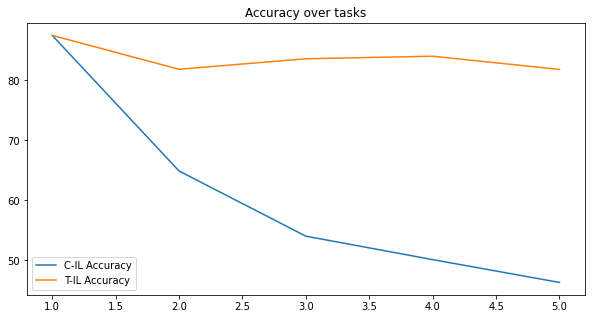

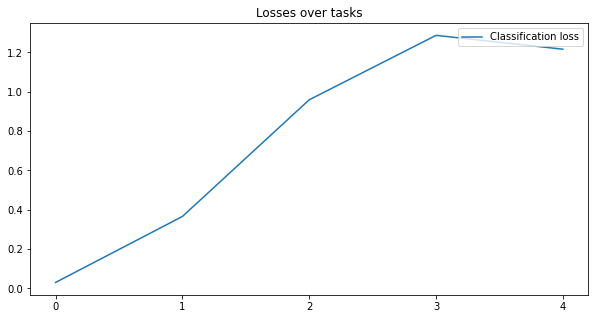

In [ ]:
# Train on CIFAR-10 only the classifier layer
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
num_cluster = 10
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Der_classifier, backbone=dataset_cifar.get_backbone_cluster(num_cluster), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=500, minibatch_size=32, alpha=0.3, beta=None, transform=dataset_cifar.get_transform())
results, results_mask_classes = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_cluster, 0, 49, 4, False)

# Classificazione multi-label utilizzando il modello in modalità single-branch

In [40]:
# ResNet18 con un unico layer classificatore. 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, avg_pool2d
from typing import List
from typing import Tuple


def conv3x3(in_planes: int, out_planes: int, stride: int=1) -> F.conv2d:
    """
    Instantiates a 3x3 convolutional layer with no bias.
    :param in_planes: number of input channels
    :param out_planes: number of output channels
    :param stride: stride of the convolution
    :return: convolutional layer
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    """
    The basic block of ResNet.
    """
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int=1) -> None:
        """
        Instantiates the basic block of the network.
        :param in_planes: the number of input channels
        :param planes: the number of channels (to be possibly expanded)
        """
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (10)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    """
    ResNet network architecture. Designed for complex datasets.
    """

    def __init__(self, block: BasicBlock, num_blocks: List[int],
                 num_classes: int, nf: int) -> None:
        """
        Instantiates the layers of the network.
        :param block: the basic ResNet block
        :param num_blocks: the number of blocks per layer
        :param num_classes: the number of output classes
        :param nf: the number of filters
        """
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.block = block
        self.num_classes = num_classes
        self.nf = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

        self._features = nn.Sequential(self.conv1,
                                       self.bn1,
                                       nn.ReLU(),
                                       self.layer1,
                                       self.layer2,
                                       self.layer3,
                                       self.layer4
                                       )
        self.classifier = self.linear

    def _make_layer(self, block: BasicBlock, planes: int,
                    num_blocks: int, stride: int) -> nn.Module:
        """
        Instantiates a ResNet layer.
        :param block: ResNet basic block
        :param planes: channels across the network
        :param num_blocks: number of blocks
        :param stride: stride
        :return: ResNet layer
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (output_classes)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)  # 64, 32, 32
        out = self.layer2(out)  # 128, 16, 16
        out = self.layer3(out)  # 256, 8, 8
        out = self.layer4(out)  # 512, 4, 4
        out = avg_pool2d(out, out.shape[2]) # 512, 1, 1
        out = out.view(out.size(0), -1)  # 512
        out1 = self.classifier(out)
        return out1

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (??)
        """
        out = self._features(x)
        out = avg_pool2d(out, out.shape[2])
        feat = out.view(out.size(0), -1)
        return feat

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (??)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (??)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (??)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)


def resnet18(nclasses: int, nf: int=64) -> ResNet:
    """
    Instantiates a ResNet18 network.
    :param nclasses: number of output classes
    :param nf: number of filters
    :return: ResNet network
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

In [41]:
# Modello per la classificazione multi-label in modalità single-branch

from torch.nn import functional as F

class Der_multi_label(ContinualModel):
    NAME = 'der'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Der_multi_label, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs):

        self.opt.zero_grad()

        outputs = self.net(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)

        if not self.buffer.is_empty():
            buf_inputs, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, logits=outputs.data)

        return loss.item()

In [42]:
# Funzione per creare tensori di label binari, da utilizzare
# all'interno della funzione di cross-entropia binaria

def binary_target(labels: torch.Tensor, cluster_labels: torch.Tensor, num_classes: int):
  # Creo un tensore delle stesse dimensioni dell'output della rete neurale
  rows = labels.shape[0]
  cols = num_classes
  targets = torch.zeros(rows, cols, dtype=torch.float) # initializes zeros array of the same dimension as the output
  # Modifico il valore delle label trasformandolo in binario
  for i in range(labels.shape.numel()):
    targets[i][labels[i].item()] = 1
    targets[i][cluster_labels[i].item()] = 1
  
  return targets

In [43]:
# Funzione per verificare il cluster più simile a ciascuna delle nuove classi del task corrente
def active_clusters(model, train_loader, num_classes, c1, c2, new_classes, new_clusters, class_indexes):

  '''
      - model --> modello usato per la classificazione
      - train_loader --> insieme dei dati appartenenti al task corrente
      - num_classes --> numero delle classi totali da classificare (classi + cluster)
      - c1 e c2 --> indici delle nuove classi del task corrente
      - new_classes --> dizionario per il mapping delle nuove classi dei task
      - new_clusters --> dizionario per il mapping dei nuovi cluster dei task (l'opposto al precedente)
      - class_indexes --> lista contenente gli indici delle classi dei task utilizzate dal classificatore
  '''

  test_transf = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465),
                              (0.2470, 0.2435, 0.2615))])
  status = model.net.training
  # Creo i tensori che conterranno i logits per i cluster più simili alle nuove classi del task
  logits_c1 = torch.empty(0)
  logits_c2 = torch.empty(0)
  logits_c1, logits_c2 = logits_c1.to(model.device), logits_c2.to(model.device)
  model.net.eval()
  # Scorro le immagini di training del task corrente
  for data in train_loader:
    transf_inputs, labels, cluster_labels = transform_input(test_transf, data)
    transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
    # Calcolo l'output del modello
    with torch.no_grad():
      outputs = model(transf_inputs)
    # Separo gli output della classe 1 da quelli della classe 2
    for i, lab in enumerate(labels):
      if(lab.item() == c1): # classe pari
        logits_c1 = torch.cat((logits_c1, outputs[i]), 0)
      else: # classe dispari
        logits_c2 = torch.cat((logits_c2, outputs[i]), 0)
  
  # Reshaping dei logit --> [num_campioni_classe, num_classi]
  logits_c1 = logits_c1.view(int(len(logits_c1) / num_classes), num_classes)
  logits_c2 = logits_c2.view(int(len(logits_c2) / num_classes), num_classes)
  # Applico la funzione di softmax ai logits di output
  m = torch.nn.Softmax(dim=1)
  softmax_out_c1 = m(logits_c1)
  softmax_out_c2 = m(logits_c2)
  # Sommo i valori di ogni classe per tutti i campioni osservati
  softmax_sum_c1 = torch.sum(softmax_out_c1, 0)
  softmax_sum_c2 = torch.sum(softmax_out_c2, 0)
  # Pongo a -inf i logit relativi alle classi del dataset (perchè già usati dal classificatore)
  for idx in class_indexes:
    softmax_sum_c1[idx] = float('-inf')
    softmax_sum_c2[idx] = float('-inf')
  # Ricavo l'indice del cluster che si attiva più frequentemente
  max_value1, cluster_index_c1 = torch.max(softmax_sum_c1, 0)
  # Maschero l'output relativo al primo cluster attivo
  softmax_sum_c2[cluster_index_c1] = float('-inf')
  max_value2, cluster_index_c2 = torch.max(softmax_sum_c2, 0)
  print("Indice del cluster più attivo per la classe 1: ", cluster_index_c1.item())
  print("Indice del cluster più attivo per la classe 2: ", cluster_index_c2.item())
  
  # Aggiungo le classi e i cluster da mappare al dizionario
  new_classes[c1] = cluster_index_c1.item()
  new_classes[c2] = cluster_index_c2.item()
  new_clusters[cluster_index_c1.item()] = c1
  new_clusters[cluster_index_c2.item()] = c2
  # Aggiungo gli indici delle nuove classi del task alla lista
  class_indexes.append(cluster_index_c1.item())
  class_indexes.append(cluster_index_c2.item())

  # Dopo l'esecuzione di questa funzione, è necessario
  # mappare le classi e i cluster con gli indici corretti del
  # classificatore (funzione map_classes())

  model.net.train(status)

In [44]:
# Funzione per mappare le nuove classi e i cluster del task corrente
def map_classes(train_data: torch.Tensor, test_data: torch.Tensor, new_classes: dict, new_clusters: dict):
  # Mappo le classi del nuovo task con quelle dei cluster più simili
  # Analogamente, mappo le classi dei cluster con quelle delle vecchie classi
  for i in range(len(train_data[1])):
    train_data[1][i] = new_classes[train_data[1][i].item()]
  for j in range(len(train_data[2])):
    if train_data[2][j].item() in new_clusters.keys():
        train_data[2][j] = float(new_clusters[int(train_data[2][j].item())])
        
  for i in range(len(test_data[1])):
    test_data[1][i] = new_classes[test_data[1][i].item()]
  for j in range(len(test_data[2])):
    if test_data[2][j].item() in new_clusters.keys():
        test_data[2][j] = float(new_clusters[int(test_data[2][j].item())])

In [ ]:
# Correzione delle label dei cluster di ogni task: vengono
# modificate le label che sono già assegnate alle classi.

# NOTA: da utilizzare solo nel caso in cui si vuole creare
# un nuovo dataset in cui ogni task contiene un numero di cluster diverso.

# Dizionari per associare le nuove label (vecchia label: nuova label)
cluster_map_t1 = {0:18, 1:19}
cluster_map_t2 = {0:16, 1:17, 2:18, 3:19}
cluster_map_t3 = {0:14, 1:15, 2:16, 3:17, 4:18, 5:19}
cluster_map_t4 = {0:12, 1:13, 2:14, 3:15, 4:16, 5:17, 6:18, 7:19}
cluster_map_t5 = {0:10, 1:11, 2:12, 3:13, 4:14, 5:15, 6:16, 7:17, 8:18, 9:19}
num_task = 5

# Correzione del training set
for i in range(num_task): # "i" indice del task
  for j in range(len(train_data[i][2])): # "j" indice del campione
    if i == 0:
      if train_data[i][2][j].item() in cluster_map_t1.keys():
        cluster_idx = train_data[i][2][j].item()
        train_data[i][2][j] = cluster_map_t1[cluster_idx]
    elif i == 1:
       if train_data[i][2][j].item() in cluster_map_t2.keys():
        cluster_idx = train_data[i][2][j].item()
        train_data[i][2][j] = cluster_map_t2[cluster_idx]
    elif i == 2:
       if train_data[i][2][j].item() in cluster_map_t3.keys():
        cluster_idx = train_data[i][2][j].item()
        train_data[i][2][j] = cluster_map_t3[cluster_idx]
    elif i == 3:
       if train_data[i][2][j].item() in cluster_map_t4.keys():
        cluster_idx = train_data[i][2][j].item()
        train_data[i][2][j] = cluster_map_t4[cluster_idx]
    else:
       if train_data[i][2][j].item() in cluster_map_t5.keys():
        cluster_idx = train_data[i][2][j].item()
        train_data[i][2][j] = cluster_map_t5[cluster_idx]

# Correzione del test set
for i in range(num_task):
  for j in range(len(test_data[i][2])):
    if i == 0:
      if test_data[i][2][j].item() in cluster_map_t1.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t1[cluster_idx]
    elif i == 1:
       if test_data[i][2][j].item() in cluster_map_t2.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t2[cluster_idx]
    elif i == 2:
       if test_data[i][2][j].item() in cluster_map_t3.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t3[cluster_idx]
    elif i == 3:
       if test_data[i][2][j].item() in cluster_map_t4.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t4[cluster_idx]
    else:
       if test_data[i][2][j].item() in cluster_map_t5.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t5[cluster_idx]

In [45]:
# Codice per il training del modello

from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Per il calcolo dell'accuratezza in T-IL
def mask_classes(outputs: torch.Tensor, num_classes: int, c1: int, c2: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param num_classes: total number of classes (classes + clusters)
    :params c1 and c2: the class indexes not to be masked
    """
    for idx in range(num_classes):
      if idx != c1 and idx!= c2:
        outputs[:, idx] = -float('inf')

# Per il calcolo dell'accuratezza in C-IL
def mask_clusters(outputs: torch.Tensor, num_classes: int, classes: list, task: int) -> None:
  """
  Given the output tensor, the dataset at hand and the current task,
  masks the former by setting the responses for the other tasks at -inf.
  It is used to obtain the results for the task-il setting.
  :param outputs: the output tensor
  :param num_classes: the total number of classes on the head of the net
  :param classes: a list containing all the class indexes used for the classes
  :param task: index for the current task
  """
  current_task_classes = classes[0: task + task + 2]
  for idx in range(num_classes):
    if idx not in current_task_classes:
      outputs[:, idx] = -float('inf')

# Per il calcolo dell'accuratezza sul clustering
def mask_classes_clustering(outputs: torch.Tensor, num_classes: int, classes: list, task: int) -> None:
  """
  Given the output tensor, the dataset at hand and the current task,
  masks the former by setting the responses for the other tasks at -inf.
  It is used to obtain the results for the task-il setting.
  :param outputs: the output tensor
  :param num_classes: the total number of classes on the head of the net
  :param classes: a list containing all the class indexes used for the classes
  :param task: index for the current task
  """
  current_task_classes = classes[0: task + task + 2]
  for idx in range(num_classes):
    if idx in current_task_classes:
      outputs[:, idx] = -float('inf')


def evaluate_cifar(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, num_classes: int, classes: list, last=False) -> Tuple[list, list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :param test_loaders: data loaders containing the test data for each task to be evalueted
    :param task: the current task index to be evalueted (only used for clustering accuracy)
    :param num_classes: the total number of classes
    :param classes: a list containing all the class indexes evalueted at this point
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task, and the clustering accuracy
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes, accs_clustering = [], [], []
    test_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        correct_cluster, total_cluster = 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            # Apply test transformation
            transf_inputs = torch.Tensor()
            for j in range(inputs.shape[0]):
              input = inputs[j].permute(1, 2, 0)
              input = np.array(input)
              img = test_transf(input)
              img = img.permute(1, 2, 0)
              transf_inputs = torch.cat((transf_inputs, img))
            transf_inputs = transf_inputs.unsqueeze(0)
            transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
            transf_inputs = transf_inputs.permute(0, 3, 1, 2)
            transf_inputs = transf_inputs.float()
            labels = labels.long()
            cluster_labels = cluster_labels.long()
            labels = labels.squeeze(1)
            cluster_labels = cluster_labels.squeeze(1)
            transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs = model(transf_inputs, k) # fornisco anche l'indice del task
              else:
                  outputs = model(transf_inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

            # Maschero gli output dei cluster
            original_outputs = outputs.clone()
            mask_clusters(outputs, num_classes, classes, k)
            _, pred = torch.max(outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
            
            if k == task:
              outputs = original_outputs.clone()
              # Maschero gli output delle classi
              mask_classes_clustering(original_outputs, num_classes, classes, k)
              _, pred_cluster = torch.max(original_outputs.data, 1) # label predette dal modello per la classificazione dei cluster
              correct_cluster += torch.sum(pred_cluster == cluster_labels).item() # calcolo il numero di predizioni corrette per il clustering
              total_cluster += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il clustering
              # Calcolo l'accuratezza per il clustering
              clustering_acc = (correct_cluster / total_cluster * 100)

            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                mask_classes(outputs, num_classes, classes[k+k], classes[k+k+1])
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

        
    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes, clustering_acc


def train_cifar(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, num_classes: int, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes, results_clustering = [], [], []
    accuracy, cluster_accuracy = [], []
    loss_classification = []
    test_loaders = list()
    train_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    checkpoint_epoch_passed = checkpoint_epoch

    # Dizionari per il mapping classi - cluster
    new_classes = {}
    new_clusters = {}

    # Lista contenente gli indici delle classi utilizzate (inizialmente solo quelle del primo task)
    class_indexes = [0, 1]

    for t in range(dataset.N_TASKS):
        model.net.train()
        if t:
            # Identificare i 2 cluster che si attivano maggiormente per le 2 classi del nuovo task
            # e mapparli al posto delle vecchie classi
            train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
            active_clusters(model, train_loader, num_classes, t+t, t+t+1, new_classes, new_clusters, class_indexes)
            map_classes(train_data[t], test_data[t], new_classes, new_clusters)
            train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
            test_loaders.append(test_loader)
            # Calcolo l'accuratezza
            accs = evaluate_cifar(model, dataset, test_loaders, t, num_classes, class_indexes, last=True)
            results[t-1] = results[t-1] + accs[0] # Accuratezze per lo scenario di C-IL
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL
        else: 
            train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
            test_loaders.append(test_loader)
            
        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, cluster_lab = data
                  # Apply train transformation
                  transf_inputs = torch.Tensor()
                  for j in range(inputs.shape[0]):
                    input = inputs[j].permute(1, 2, 0)
                    input = np.array(input)
                    img = train_transf(input)
                    img = img.permute(1, 2, 0)
                    transf_inputs = torch.cat((transf_inputs, img))
                  transf_inputs = transf_inputs.unsqueeze(0)
                  transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
                  transf_inputs = transf_inputs.permute(0, 3, 1, 2)
                  transf_inputs = transf_inputs.float()
                  labels = labels.long()
                  cluster_lab = cluster_lab.long()
                  labels = labels.squeeze(1)
                  cluster_lab = cluster_lab.squeeze(1)
                  transf_inputs, labels = transf_inputs.to(model.device), labels.to(
                      model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  inputs = inputs / 255
                  # Ottengo le label binarie da utilizzare per il calcolo della loss
                  targets = binary_target(labels, cluster_lab, num_classes)
                  targets = targets.to(model.device)
                  loss = model.observe(transf_inputs, targets, inputs)
                  sum_classification_loss += loss
                  progress_bar(i, len(train_loader), epoch, t, loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (epoch, t))
            loss_classification.append(sum_classification_loss / len(train_loader))
        accs = evaluate_cifar(model, dataset, test_loaders, t, num_classes, class_indexes) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        clustering_acc = accs[2] # accuratezza per le classi dei cluster
        accs = accs[0:2] # rimuovo i risultati di clustering prima di calcolare la media
        print(accs)
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task) per i 2 scenari di C-IL e T-IL
        accuracy.append(mean_acc)
        cluster_accuracy.append(clustering_acc)
        print_mean_accuracy_clustering(mean_acc, clustering_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy, cluster_accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy', 'Clustering Accuracy'))
    
    # Plotting della loss di classificazione
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Loss over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, label="Classification loss")
    plt.legend(loc="upper right")
    #plt.gca().legend('Classification loss')
    return results, results_mask_classes, results_clustering

/tmp/ipykernel_1473/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1473/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-10 | 19:23 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.19535102

([92.2], [92.2])



Accuracy for 1 task(s): 	 [Class-IL]: 92.2 % 	 [Task-IL]: 92.2 % 	 [Clustering]: 64.5 %



Indice del cluster più attivo per la classe 1:  8
Indice del cluster più attivo per la classe 2:  17


[ 02-10 | 19:58 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.36389327

([90.10000000000001, 84.3], [90.10000000000001, 85.5])



Accuracy for 2 task(s): 	 [Class-IL]: 87.2 % 	 [Task-IL]: 87.8 % 	 [Clustering]: 62.1 %



Indice del cluster più attivo per la classe 1:  14
Indice del cluster più attivo per la classe 2:  19


[ 02-10 | 20:32 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.40572807

([87.4, 80.0, 82.39999999999999], [87.4, 83.7, 91.0])



Accuracy for 3 task(s): 	 [Class-IL]: 83.27 % 	 [Task-IL]: 87.37 % 	 [Clustering]: 53.6 %



Indice del cluster più attivo per la classe 1:  2
Indice del cluster più attivo per la classe 2:  3


[ 02-10 | 21:06 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.25347281

([91.2, 76.8, 79.4, 92.5], [91.2, 79.10000000000001, 89.0, 95.3])



Accuracy for 4 task(s): 	 [Class-IL]: 84.98 % 	 [Task-IL]: 88.65 % 	 [Clustering]: 56.4 %



Indice del cluster più attivo per la classe 1:  12
Indice del cluster più attivo per la classe 2:  11


[ 02-10 | 21:41 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.19281527
Accuracy for 5 task(s): 	 [Class-IL]: 83.56 % 	 [Task-IL]: 88.92 % 	 [Clustering]: 53.5 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([85.9, 76.5, 73.3, 86.0, 96.1], [85.9, 78.8, 87.4, 94.8, 97.7])


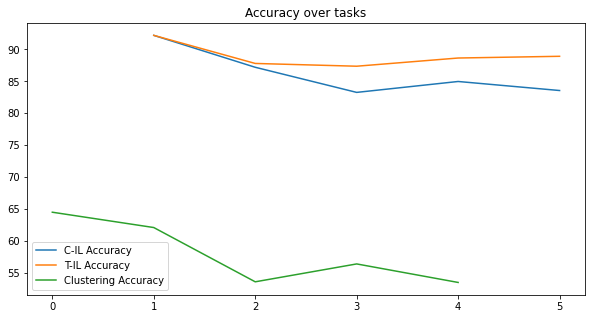

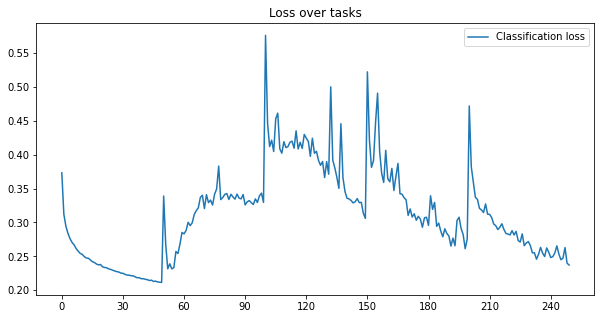

In [ ]:
train_path = "/home/marco_palumbo/data/train_data_multi_class.pkl"
test_path = "/home/marco_palumbo/data/test_data_multi_class.pkl"
open_file_1 = open(train_path, "rb")
open_file_2 = open(test_path, "rb")
train_data = pickle.load(open_file_1)
test_data = pickle.load(open_file_2)
open_file_1.close()
open_file_2.close()
dataset_cifar = get_dataset("seq-cifar10", 32, True)
num_classes = 20
model_cifar = get_model(Der_multi_label, backbone=resnet18(num_classes), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=5120, minibatch_size=32, alpha=0.3, beta=None, transform=dataset_cifar.get_transform())
results, results_mask_classes, results_clustering = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_classes, 0, None, True)

# Esperimenti su CIFAR-10 con DER++

In [ ]:
# Modello di DER++ per la classificazione multi-label

from torch.nn import functional as F

class Derpp_multi_label(ContinualModel):
    NAME = 'derpp'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform):
        super(Derpp_multi_label, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, beta, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs):

        self.opt.zero_grad()

        outputs = self.net(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, labels)

        if not self.buffer.is_empty():
            buf_inputs, _, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)
            
            buf_inputs, buf_labels, _ = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs = self.net(buf_inputs)
            casted_labels = buf_labels.double()
            loss += self.beta * F.binary_cross_entropy_with_logits(buf_outputs, casted_labels)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, labels=labels, logits=outputs.data)

        return loss.item()

/tmp/ipykernel_1468/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1468/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-26 | 22:20 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.27598062

([93.8], [93.8])



Accuracy for 1 task(s): 	 [Class-IL]: 93.8 % 	 [Task-IL]: 93.8 % 	 [Clustering]: 65.8 %



Indice del cluster più attivo per la classe 1:  8
Indice del cluster più attivo per la classe 2:  17


[ 02-26 | 23:03 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.21133904

([90.3, 83.8], [90.3, 85.2])



Accuracy for 2 task(s): 	 [Class-IL]: 87.05 % 	 [Task-IL]: 87.75 % 	 [Clustering]: 60.9 %



Indice del cluster più attivo per la classe 1:  16
Indice del cluster più attivo per la classe 2:  19


[ 02-26 | 23:47 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.18541056

([90.5, 74.8, 83.6], [90.5, 78.9, 90.4])



Accuracy for 3 task(s): 	 [Class-IL]: 82.97 % 	 [Task-IL]: 86.6 % 	 [Clustering]: 51.0 %



Indice del cluster più attivo per la classe 1:  12
Indice del cluster più attivo per la classe 2:  3


[ 02-27 | 00:30 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.12873338

([89.8, 72.7, 74.3, 91.7], [89.8, 76.9, 87.0, 96.7])



Accuracy for 4 task(s): 	 [Class-IL]: 82.12 % 	 [Task-IL]: 87.6 % 	 [Clustering]: 58.0 %



Indice del cluster più attivo per la classe 1:  4
Indice del cluster più attivo per la classe 2:  6


[ 02-27 | 01:13 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.09441682
Accuracy for 5 task(s): 	 [Class-IL]: 80.22 % 	 [Task-IL]: 85.44 % 	 [Clustering]: 48.5 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([80.80000000000001, 70.6, 73.2, 82.89999999999999, 93.60000000000001], [80.80000000000001, 74.3, 83.89999999999999, 93.0, 95.19999999999999])


/tmp/ipykernel_1468/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1468/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-27 | 01:56 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.20334445

([93.7], [93.7])



Accuracy for 1 task(s): 	 [Class-IL]: 93.7 % 	 [Task-IL]: 93.7 % 	 [Clustering]: 63.7 %



Indice del cluster più attivo per la classe 1:  19
Indice del cluster più attivo per la classe 2:  17


[ 02-27 | 02:39 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.17940491

([91.10000000000001, 84.0], [91.10000000000001, 85.9])



Accuracy for 2 task(s): 	 [Class-IL]: 87.55 % 	 [Task-IL]: 88.5 % 	 [Clustering]: 60.9 %



Indice del cluster più attivo per la classe 1:  14
Indice del cluster più attivo per la classe 2:  2


[ 02-27 | 03:22 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.17183261

([89.7, 78.10000000000001, 81.2], [89.7, 80.30000000000001, 88.0])



Accuracy for 3 task(s): 	 [Class-IL]: 83.0 % 	 [Task-IL]: 86.0 % 	 [Clustering]: 51.3 %



Indice del cluster più attivo per la classe 1:  12
Indice del cluster più attivo per la classe 2:  3


[ 02-27 | 04:05 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.09572863

([86.0, 74.9, 69.5, 91.3], [86.0, 78.10000000000001, 79.80000000000001, 95.0])



Accuracy for 4 task(s): 	 [Class-IL]: 80.42 % 	 [Task-IL]: 84.72 % 	 [Clustering]: 55.5 %



Indice del cluster più attivo per la classe 1:  4
Indice del cluster più attivo per la classe 2:  8


[ 02-27 | 04:48 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.13523994
Accuracy for 5 task(s): 	 [Class-IL]: 80.2 % 	 [Task-IL]: 85.34 % 	 [Clustering]: 51.8 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([82.89999999999999, 73.4, 69.8, 84.2, 90.7], [82.89999999999999, 76.1, 80.5, 93.7, 93.5])


/tmp/ipykernel_1468/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1468/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-27 | 05:32 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.24479938

([96.0], [96.0])



Accuracy for 1 task(s): 	 [Class-IL]: 96.0 % 	 [Task-IL]: 96.0 % 	 [Clustering]: 67.9 %



Indice del cluster più attivo per la classe 1:  11
Indice del cluster più attivo per la classe 2:  8


[ 02-27 | 06:15 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.21898812

([92.2, 82.39999999999999], [92.2, 84.2])



Accuracy for 2 task(s): 	 [Class-IL]: 87.3 % 	 [Task-IL]: 88.2 % 	 [Clustering]: 58.5 %



Indice del cluster più attivo per la classe 1:  16
Indice del cluster più attivo per la classe 2:  19


[ 02-27 | 06:58 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.17859086

([90.8, 73.1, 86.9], [90.8, 79.10000000000001, 90.60000000000001])



Accuracy for 3 task(s): 	 [Class-IL]: 83.6 % 	 [Task-IL]: 86.83 % 	 [Clustering]: 54.6 %



Indice del cluster più attivo per la classe 1:  17
Indice del cluster più attivo per la classe 2:  3


[ 02-27 | 07:41 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.11817004

([90.10000000000001, 68.10000000000001, 75.3, 91.3], [90.10000000000001, 76.4, 86.3, 95.19999999999999])



Accuracy for 4 task(s): 	 [Class-IL]: 81.2 % 	 [Task-IL]: 87.0 % 	 [Clustering]: 54.3 %



Indice del cluster più attivo per la classe 1:  12
Indice del cluster più attivo per la classe 2:  4


[ 02-27 | 08:24 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.10461396
Accuracy for 5 task(s): 	 [Class-IL]: 78.04 % 	 [Task-IL]: 85.82 % 	 [Clustering]: 52.5 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([86.8, 71.39999999999999, 69.39999999999999, 70.39999999999999, 92.2], [86.8, 72.89999999999999, 84.0, 89.8, 95.6])


/tmp/ipykernel_1468/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1468/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-27 | 09:07 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.19375385

([95.3], [95.3])



Accuracy for 1 task(s): 	 [Class-IL]: 95.3 % 	 [Task-IL]: 95.3 % 	 [Clustering]: 66.6 %



Indice del cluster più attivo per la classe 1:  19
Indice del cluster più attivo per la classe 2:  8


[ 02-27 | 09:51 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.12688698

([92.0, 83.6], [92.0, 85.8])



Accuracy for 2 task(s): 	 [Class-IL]: 87.8 % 	 [Task-IL]: 88.9 % 	 [Clustering]: 61.3 %



Indice del cluster più attivo per la classe 1:  16
Indice del cluster più attivo per la classe 2:  2


[ 02-27 | 10:34 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.14040512

([90.5, 71.2, 86.7], [90.5, 76.2, 88.8])



Accuracy for 3 task(s): 	 [Class-IL]: 82.8 % 	 [Task-IL]: 85.17 % 	 [Clustering]: 57.7 %



Indice del cluster più attivo per la classe 1:  12
Indice del cluster più attivo per la classe 2:  17


[ 02-27 | 11:17 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.12717204

([89.4, 68.60000000000001, 67.9, 92.30000000000001], [89.4, 75.5, 78.60000000000001, 97.3])



Accuracy for 4 task(s): 	 [Class-IL]: 79.55 % 	 [Task-IL]: 85.2 % 	 [Clustering]: 57.3 %



Indice del cluster più attivo per la classe 1:  6
Indice del cluster più attivo per la classe 2:  3


[ 02-27 | 12:00 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.11991861
Accuracy for 5 task(s): 	 [Class-IL]: 78.26 % 	 [Task-IL]: 83.64 % 	 [Clustering]: 50.1 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([80.80000000000001, 68.30000000000001, 70.0, 79.80000000000001, 92.4], [80.80000000000001, 73.1, 76.1, 93.60000000000001, 94.6])


/tmp/ipykernel_1468/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1468/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
[ 02-27 | 12:43 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.18302645

([94.8], [94.8])



Accuracy for 1 task(s): 	 [Class-IL]: 94.8 % 	 [Task-IL]: 94.8 % 	 [Clustering]: 67.6 %



Indice del cluster più attivo per la classe 1:  8
Indice del cluster più attivo per la classe 2:  11


[ 02-27 | 13:26 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.16069078

([90.7, 85.6], [90.7, 87.1])



Accuracy for 2 task(s): 	 [Class-IL]: 88.15 % 	 [Task-IL]: 88.9 % 	 [Clustering]: 59.2 %



Indice del cluster più attivo per la classe 1:  14
Indice del cluster più attivo per la classe 2:  19


[ 02-27 | 14:09 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.18744572

([89.1, 75.4, 85.3], [89.1, 80.5, 86.6])



Accuracy for 3 task(s): 	 [Class-IL]: 83.27 % 	 [Task-IL]: 85.4 % 	 [Clustering]: 55.5 %



Indice del cluster più attivo per la classe 1:  16
Indice del cluster più attivo per la classe 2:  17


[ 02-27 | 14:53 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.21660733

([87.6, 72.3, 69.19999999999999, 95.89999999999999], [87.6, 75.7, 82.8, 97.3])



Accuracy for 4 task(s): 	 [Class-IL]: 81.25 % 	 [Task-IL]: 85.85 % 	 [Clustering]: 58.4 %



Indice del cluster più attivo per la classe 1:  4
Indice del cluster più attivo per la classe 2:  2


[ 02-27 | 15:36 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.09091228
Accuracy for 5 task(s): 	 [Class-IL]: 82.0 % 	 [Task-IL]: 85.92 % 	 [Clustering]: 60.0 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([83.0, 72.1, 73.6, 85.8, 95.5], [83.0, 74.7, 82.39999999999999, 93.5, 96.0])


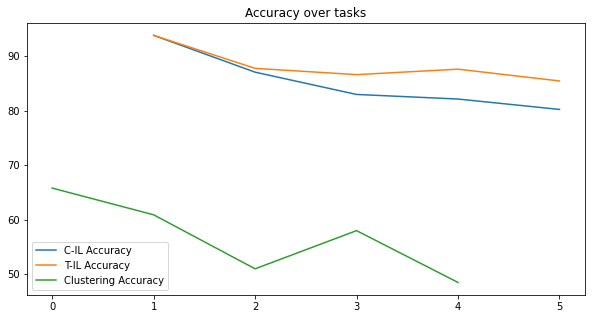

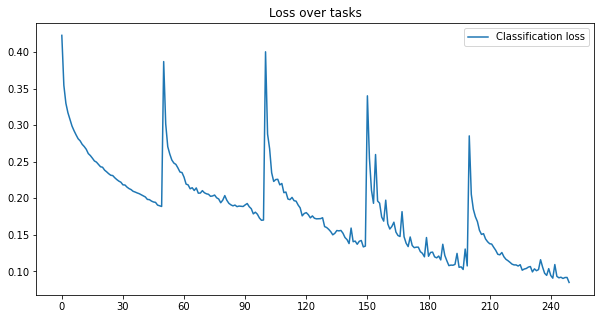

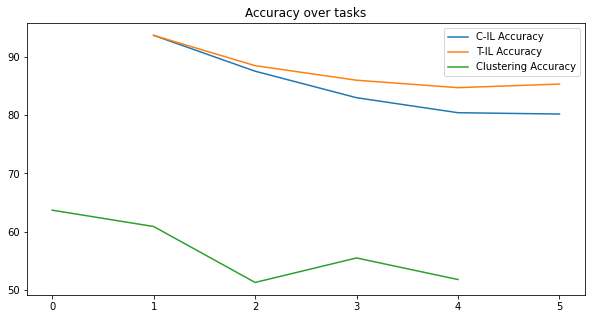

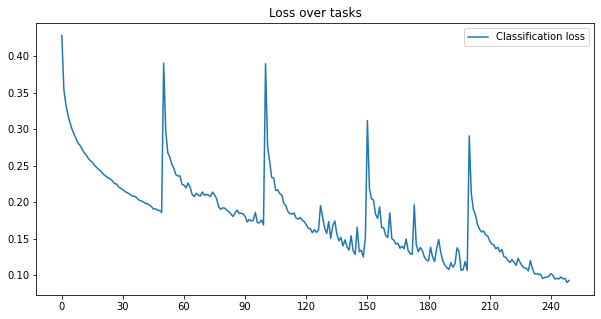

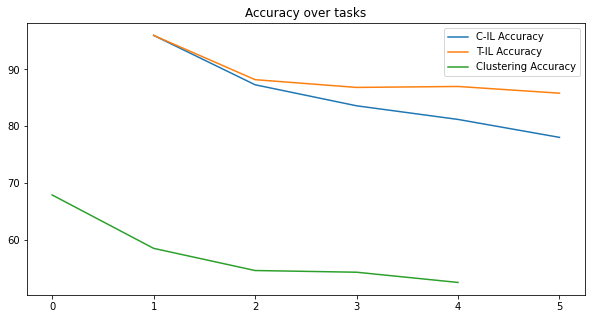

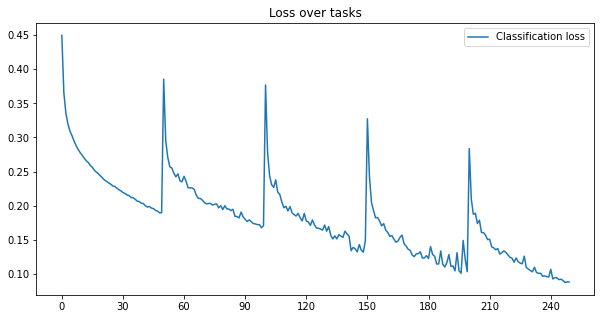

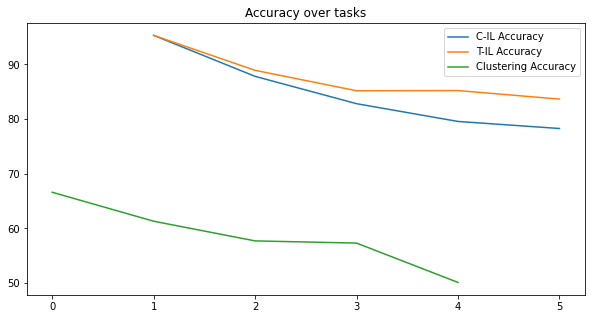

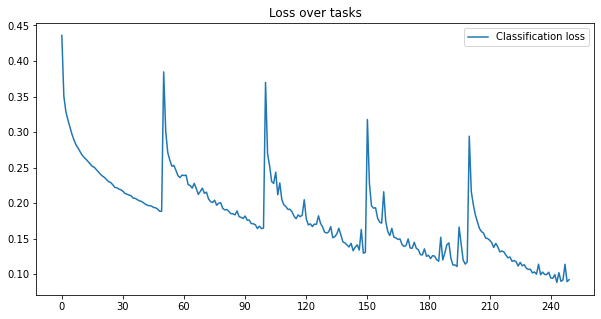

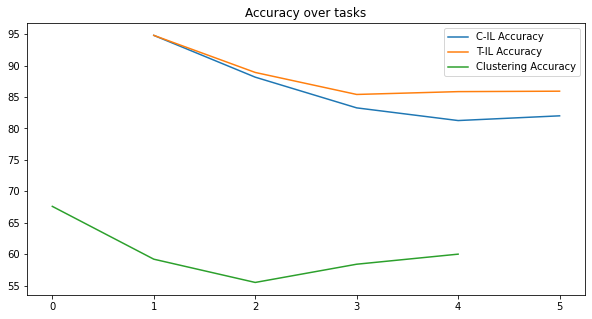

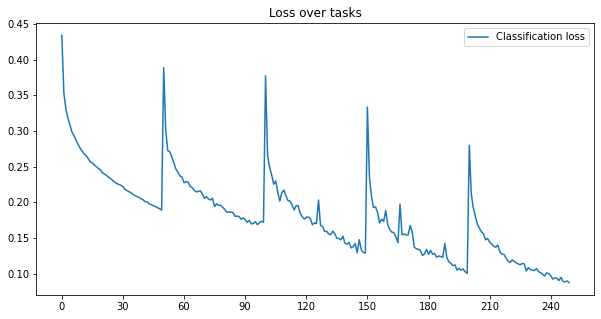

In [ ]:
train_path = "/home/marco_palumbo/data/train_data_multi_class.pkl"
test_path = "/home/marco_palumbo/data/test_data_multi_class.pkl"
for i in range(10):
    open_file_1 = open(train_path, "rb")
    open_file_2 = open(test_path, "rb")
    train_data = pickle.load(open_file_1)
    test_data = pickle.load(open_file_2)
    open_file_1.close()
    open_file_2.close()
    dataset_cifar = get_dataset("seq-cifar10", 32, True)
    num_classes = 20
    model_cifar = get_model(Derpp_multi_label, backbone=resnet18(num_classes), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=500, minibatch_size=32, alpha=0.2, beta=0.5, transform=dataset_cifar.get_transform())
    results, results_mask_classes, results_clustering = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, num_classes, 0, None, True)

# Esperimenti su MNIST utilizzando il modello in modalità single-branch

In [46]:
from torch.utils.data import TensorDataset, DataLoader

# Questa funzione effettua il clustering per ogni partizione/task di MNIST
# e ritorna i dati clusterizzati

def clustered_mnist(clusters: list):
  x_train_list = list()
  y_train_list = list()
  not_aug_x_train_list = list()
  cluster_lab_train_list = list()
  x_test_list = list()
  y_test_list = list()
  cluster_lab_test_list = list()
  dataset_mnist = get_dataset("seq-mnist", 10, True)
  for i in range(dataset_mnist.N_TASKS):
    input_train = torch.Tensor()
    label_train = torch.Tensor()
    not_aug_input_train = torch.Tensor()
    input_test = torch.Tensor()
    label_test = torch.Tensor()
    train_loader, test_loader = dataset_mnist.get_data_loaders()
    for j, data in enumerate(train_loader):
      inputs, labels, not_aug_inputs = data
      input_train = torch.cat((input_train, inputs), 0)
      label_train = torch.cat((label_train, labels), 0)
      not_aug_input_train = torch.cat((not_aug_input_train, not_aug_inputs), 0)
    x_train = input_train
    y_train = label_train
    y_train = y_train.type(torch.int64)
    not_aug_x_train = not_aug_input_train
    for k, data in enumerate(test_loader):
      inputs, labels = data
      input_test = torch.cat((input_test, inputs), 0)
      label_test = torch.cat((label_test, labels), 0)
    x_test = input_test
    y_test = label_test
    y_test = y_test.type(torch.int64)

    # Clustering train set
    input_train = input_train.squeeze_(1)
    input_train = input_train.reshape(len(input_train),-1)
    cluster_labels_train, centroids = K_means_cluster(clusters[i], input_train)
    cluster_labels_train = torch.from_numpy(cluster_labels_train)
    cluster_labels_train = cluster_labels_train.type(torch.int64)

    # Clustering test set
    input_test = input_test.squeeze_(1)
    input_test = input_test.reshape(len(input_test),-1)
    cluster_labels_test, centroids = K_means_cluster(clusters[i], input_test)
    cluster_labels_test = torch.from_numpy(cluster_labels_test)
    cluster_labels_test = cluster_labels_test.type(torch.int64)

    x_train_list.append(x_train)
    y_train_list.append(y_train)
    not_aug_x_train_list.append(not_aug_x_train)
    cluster_lab_train_list.append(cluster_labels_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    cluster_lab_test_list.append(cluster_labels_test)

  train_data = list(zip(x_train_list, y_train_list, not_aug_x_train_list, cluster_lab_train_list))
  test_data = list(zip(x_test_list, y_test_list, cluster_lab_test_list))
    
  return train_data, test_data

In [ ]:
clusters = [18, 16, 14, 12, 10]
train_data, test_data = clustered_mnist(clusters)

In [ ]:
# Correzione delle label dei cluster di ogni task: vengono
# modificate le label che sono già assegnate alle classi.

# NOTA: da utilizzare solo nel caso in cui si vuole creare
# un nuovo dataset in cui ogni task contiene un numero di cluster diverso.

# Dizionari per associare le nuove label (vecchia label: nuova label)
cluster_map_t1 = {0:18, 1:19}
cluster_map_t2 = {0:16, 1:17, 2:18, 3:19}
cluster_map_t3 = {0:14, 1:15, 2:16, 3:17, 4:18, 5:19}
cluster_map_t4 = {0:12, 1:13, 2:14, 3:15, 4:16, 5:17, 6:18, 7:19}
cluster_map_t5 = {0:10, 1:11, 2:12, 3:13, 4:14, 5:15, 6:16, 7:17, 8:18, 9:19}
num_task = 5

# Correzione del training set
for i in range(num_task): # "i" indice del task
  for j in range(len(train_data[i][3])): # "j" indice del campione
    if i == 0:
      if train_data[i][3][j].item() in cluster_map_t1.keys():
        cluster_idx = train_data[i][3][j].item()
        train_data[i][3][j] = cluster_map_t1[cluster_idx]
    elif i == 1:
       if train_data[i][3][j].item() in cluster_map_t2.keys():
        cluster_idx = train_data[i][3][j].item()
        train_data[i][3][j] = cluster_map_t2[cluster_idx]
    elif i == 2:
       if train_data[i][3][j].item() in cluster_map_t3.keys():
        cluster_idx = train_data[i][3][j].item()
        train_data[i][3][j] = cluster_map_t3[cluster_idx]
    elif i == 3:
       if train_data[i][3][j].item() in cluster_map_t4.keys():
        cluster_idx = train_data[i][3][j].item()
        train_data[i][3][j] = cluster_map_t4[cluster_idx]
    else:
       if train_data[i][3][j].item() in cluster_map_t5.keys():
        cluster_idx = train_data[i][3][j].item()
        train_data[i][3][j] = cluster_map_t5[cluster_idx]

# Correzione del test set
for i in range(num_task):
  for j in range(len(test_data[i][2])):
    if i == 0:
      if test_data[i][2][j].item() in cluster_map_t1.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t1[cluster_idx]
    elif i == 1:
       if test_data[i][2][j].item() in cluster_map_t2.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t2[cluster_idx]
    elif i == 2:
       if test_data[i][2][j].item() in cluster_map_t3.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t3[cluster_idx]
    elif i == 3:
       if test_data[i][2][j].item() in cluster_map_t4.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t4[cluster_idx]
    else:
       if test_data[i][2][j].item() in cluster_map_t5.keys():
        cluster_idx = test_data[i][2][j].item()
        test_data[i][2][j] = cluster_map_t5[cluster_idx]

In [ ]:
# Save dataset
import os
import sys
import pickle
file_name_1 = "mnist_train_data_multilabel.pkl"
file_name_2 = "mnist_test_data_multilabel.pkl"
open_file = open(file_name_1, "wb")
pickle.dump(train_data, open_file)
open_file.close()
open_file = open(file_name_2, "wb")
pickle.dump(test_data, open_file)
open_file.close()

In [ ]:
# Import / Export MNIST dataset with cluster labels
import os
import sys
import pickle

train_path = "/home/marco_palumbo/data/mnist_train_data_multilabel.pkl"
test_path = "/home/marco_palumbo/data/mnist_test_data_multilabel.pkl"
open_file_1 = open(train_path, "rb")
open_file_2 = open(test_path, "rb")
train_data = pickle.load(open_file_1)
test_data = pickle.load(open_file_2)
open_file_1.close()
open_file_2.close()

print(train_data[0][0].shape)
print(train_data[0][3].max())

In [47]:
from torch.utils.data import TensorDataset, DataLoader

# Create data loaders for train and test data on MNIST
def get_dataloaders_mnist(train_data: Tuple, test_data: Tuple, batch_size: int):
  train_x = torch.tensor(train_data[0])
  train_x_not_aug = torch.tensor(train_data[2])
  train_y = torch.tensor(train_data[1])
  train_l = torch.tensor(train_data[3].clone().detach(), dtype=torch.float32)
  test_x = torch.tensor(test_data[0])
  test_y = torch.tensor(test_data[1])
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
  
  # Create loaders
  my_dataset_train = TensorDataset(train_x, train_y, train_x_not_aug, train_l)
  my_dataset_test = TensorDataset(test_x, test_y, test_l)
  my_dataloader_train = DataLoader(my_dataset_train, batch_size, True) # create dataloader and shuffle data
  my_dataloader_test = DataLoader(my_dataset_test, batch_size, True)
  return my_dataloader_train, my_dataloader_test

In [48]:
# backbone per MNIST con un unico classificatore

import torch
import torch.nn as nn
from typing import Tuple


class MNISTMLP(nn.Module):
    """
    Network composed of two hidden layers, each containing 100 ReLU activations.
    Designed for the MNIST dataset.
    """

    def __init__(self, input_size: int, output_size: int) -> None:
        """
        Instantiates the layers of the network.
        :param input_size: the size of the input data
        :param output_size: the size of the output
        """
        super(MNISTMLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, 100)
        self.fc2 = nn.Linear(100, 100)

        self._features = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
        )
        self.classifier = nn.Linear(100, self.output_size)
        self.reset_parameters()

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (100)
        """
        x = x.view(-1, num_flat_features(x))
        return self._features(x)

    def reset_parameters(self) -> None:
        """
        Calls the Xavier parameter initialization function.
        """
        self._features.apply(xavier)
        self.classifier.apply(xavier)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (output_size)
        """
        x = x.view(-1, num_flat_features(x))
        out = self._features(x)
        out1 = self.classifier(out)
        return out1

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                    + 100 * output_size + output_size)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (input_size * 100
                    + 100 + 100 * 100 + 100 + 100 * output_size + output_size)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                   + 100 * output_size + output_size)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)

    def get_grads_list(self):
        """
        Returns a list containing the gradients (a tensor for each layer).
        :return: gradients list
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return grads

In [49]:
# Funzione per verificare il cluster più simile a ciascuna delle nuove classi del task corrente
def active_clusters_mnist(model, train_loader, num_classes, c1, c2, new_classes, new_clusters, class_indexes):

  '''
      - model --> modello usato per la classificazione
      - train_loader --> insieme dei dati appartenenti al task corrente
      - num_classes --> numero delle classi totali da classificare (classi + cluster)
      - c1 e c2 --> indici delle nuove classi del task corrente
      - new_classes --> dizionario per il mapping delle nuove classi dei task
      - new_clusters --> dizionario per il mapping dei nuovi cluster dei task (l'opposto al precedente)
      - class_indexes --> lista contenente gli indici delle classi dei task utilizzate dal classificatore
  '''

  status = model.net.training
  # Creo i tensori che conterranno i logits per i cluster più simili alle nuove classi del task
  logits_c1 = torch.empty(0)
  logits_c2 = torch.empty(0)
  logits_c1, logits_c2 = logits_c1.to(model.device), logits_c2.to(model.device)
  model.net.eval()
  # Scorro le immagini di training del task corrente
  for data in train_loader:
    inputs, labels, not_aug_inputs, cluster_labels = data
    inputs, labels = inputs.to(model.device), labels.to(model.device)
    not_aug_inputs, cluster_labels = not_aug_inputs.to(model.device), cluster_labels.to(model.device)
    # Calcolo l'output del modello
    with torch.no_grad():
      outputs = model(inputs)
    # Separo gli output della classe 1 da quelli della classe 2
    for i, lab in enumerate(labels):
      if(lab.item() == c1): # classe pari
        logits_c1 = torch.cat((logits_c1, outputs[i]), 0)
      else: # classe dispari
        logits_c2 = torch.cat((logits_c2, outputs[i]), 0)
  
  # Reshaping dei logit --> [num_campioni_classe, num_classi]
  logits_c1 = logits_c1.view(int(len(logits_c1) / num_classes), num_classes)
  logits_c2 = logits_c2.view(int(len(logits_c2) / num_classes), num_classes)
  # Applico la funzione di softmax ai logits di output
  m = torch.nn.Softmax(dim=1)
  softmax_out_c1 = m(logits_c1)
  softmax_out_c2 = m(logits_c2)
  # Sommo i valori di ogni classe per tutti i campioni osservati
  softmax_sum_c1 = torch.sum(softmax_out_c1, 0)
  softmax_sum_c2 = torch.sum(softmax_out_c2, 0)
  # Pongo a -inf i logit relativi alle classi del dataset (perchè già usati dal classificatore)
  for idx in class_indexes:
    softmax_sum_c1[idx] = float('-inf')
    softmax_sum_c2[idx] = float('-inf')
  # Ricavo l'indice del cluster che si attiva più frequentemente
  max_value1, cluster_index_c1 = torch.max(softmax_sum_c1, 0)
  # Maschero l'output relativo al primo cluster attivo
  softmax_sum_c2[cluster_index_c1] = float('-inf')
  max_value2, cluster_index_c2 = torch.max(softmax_sum_c2, 0)
  print("Indice del cluster più attivo per la classe 1: ", cluster_index_c1.item())
  print("Indice del cluster più attivo per la classe 2: ", cluster_index_c2.item())
  
  # Aggiungo le classi e i cluster da mappare al dizionario
  new_classes[c1] = cluster_index_c1.item()
  new_classes[c2] = cluster_index_c2.item()
  new_clusters[cluster_index_c1.item()] = c1
  new_clusters[cluster_index_c2.item()] = c2
  # Aggiungo gli indici delle nuove classi del task alla lista
  class_indexes.append(cluster_index_c1.item())
  class_indexes.append(cluster_index_c2.item())

  # Dopo l'esecuzione di questa funzione, è necessario
  # mappare le classi e i cluster con gli indici corretti del
  # classificatore (funzione map_classes())

  model.net.train(status)

In [50]:
# Funzione per mappare le nuove classi e i cluster del task corrente
def map_classes_mnist(train_data: torch.Tensor, test_data: torch.Tensor, new_classes: dict, new_clusters: dict):
  # Mappo le classi del nuovo task con quelle dei cluster più simili
  # Analogamente, mappo le classi dei cluster con quelle delle vecchie classi
  for i in range(len(train_data[1])):
    train_data[1][i] = new_classes[train_data[1][i].item()]
  for j in range(len(train_data[3])):
    if train_data[3][j].item() in new_clusters.keys():
        train_data[3][j] = float(new_clusters[int(train_data[3][j].item())])
        
  for i in range(len(test_data[1])):
    test_data[1][i] = new_classes[test_data[1][i].item()]
  for j in range(len(test_data[2])):
    if test_data[2][j].item() in new_clusters.keys():
        test_data[2][j] = float(new_clusters[int(test_data[2][j].item())])

In [51]:
# Codice per il training del modello

from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Per il calcolo dell'accuratezza in T-IL
def mask_classes(outputs: torch.Tensor, num_classes: int, c1: int, c2: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param num_classes: total number of classes (classes + clusters)
    :params c1 and c2: the class indexes not to be masked
    """
    for idx in range(num_classes):
      if idx != c1 and idx!= c2:
        outputs[:, idx] = -float('inf')

# Per il calcolo dell'accuratezza in C-IL
def mask_clusters(outputs: torch.Tensor, num_classes: int, classes: list, task: int) -> None:
  """
  Given the output tensor, the dataset at hand and the current task,
  masks the former by setting the responses for the other tasks at -inf.
  It is used to obtain the results for the task-il setting.
  :param outputs: the output tensor
  :param num_classes: the total number of classes on the head of the net
  :param classes: a list containing all the class indexes used for the classes
  :param task: index for the current task
  """
  current_task_classes = classes[0: task + task + 2]
  for idx in range(num_classes):
    if idx not in current_task_classes:
      outputs[:, idx] = -float('inf')

# Per il calcolo dell'accuratezza sul clustering
def mask_classes_clustering(outputs: torch.Tensor, num_classes: int, classes: list, task: int) -> None:
  """
  Given the output tensor, the dataset at hand and the current task,
  masks the former by setting the responses for the other tasks at -inf.
  It is used to obtain the results for the task-il setting.
  :param outputs: the output tensor
  :param num_classes: the total number of classes on the head of the net
  :param classes: a list containing all the class indexes used for the classes
  :param task: index for the current task
  """
  current_task_classes = classes[0: task + task + 2]
  for idx in range(num_classes):
    if idx in current_task_classes:
      outputs[:, idx] = -float('inf')


def evaluate_mnist(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, task: int, num_classes: int, classes: list, last=False) -> Tuple[list, list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :param test_loaders: data loaders containing the test data for each task to be evalueted
    :param task: the current task index to be evalueted (only used for clustering accuracy)
    :param num_classes: the total number of classes
    :param classes: a list containing all the class indexes evalueted at this point
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task, and the clustering accuracy
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes, accs_clustering = [], [], []
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        correct_cluster, total_cluster = 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            labels = labels.type(torch.int64)
            inputs = torch.unsqueeze(inputs, 1)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs = model(inputs, k) # fornisco anche l'indice del task
              else:
                  outputs = model(inputs) # shape = [batch_size, 10], tranne per l'ultimo mini-batch

            # Maschero gli output dei cluster
            original_outputs = outputs.clone()
            mask_clusters(outputs, num_classes, classes, k)
            _, pred = torch.max(outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
            
            if k == task:
              outputs = original_outputs.clone()
              # Maschero gli output delle classi
              mask_classes_clustering(original_outputs, num_classes, classes, k)
              _, pred_cluster = torch.max(original_outputs.data, 1) # label predette dal modello per la classificazione dei cluster
              correct_cluster += torch.sum(pred_cluster == cluster_labels).item() # calcolo il numero di predizioni corrette per il clustering
              total_cluster += cluster_labels.shape[0] # numero di campioni totali valutati fino a questo momento per il clustering
              # Calcolo l'accuratezza per il clustering
              clustering_acc = (correct_cluster / total_cluster * 100)

            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                mask_classes(outputs, num_classes, classes[k+k], classes[k+k+1])
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

        
    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes, clustering_acc


def train_mnist(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, num_classes: int, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes, results_clustering = [], [], []
    accuracy, cluster_accuracy = [], []
    loss_classification = []
    test_loaders = list()
    checkpoint_epoch_passed = checkpoint_epoch

    # Dizionari per il mapping classi - cluster
    new_classes = {}
    new_clusters = {}

    # Lista contenente gli indici delle classi utilizzate (inizialmente solo quelle del primo task)
    class_indexes = [0, 1]

    for t in range(dataset.N_TASKS):
        model.net.train()
        if t:
            # Identificare i 2 cluster che si attivano maggiormente per le 2 classi del nuovo task
            # e mapparli al posto delle vecchie classi
            train_loader, test_loader = get_dataloaders_mnist(train_data[t], test_data[t], dataset.batch_size)
            active_clusters_mnist(model, train_loader, num_classes, t+t, t+t+1, new_classes, new_clusters, class_indexes)
            map_classes_mnist(train_data[t], test_data[t], new_classes, new_clusters)
            train_loader, test_loader = get_dataloaders_mnist(train_data[t], test_data[t], dataset.batch_size)
            test_loaders.append(test_loader)
            # Calcolo l'accuratezza
            accs = evaluate_mnist(model, dataset, test_loaders, t, num_classes, class_indexes, last=True)
            results[t-1] = results[t-1] + accs[0] # Accuratezze per lo scenario di C-IL
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL
        else: 
            train_loader, test_loader = get_dataloaders_mnist(train_data[t], test_data[t], dataset.batch_size)
            test_loaders.append(test_loader)
            
        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49 + 1
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed + 1
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, not_aug_inputs, cluster_lab = data
                  inputs, labels = inputs.to(model.device), labels.to(
                    model.device)
                  not_aug_inputs = not_aug_inputs.to(model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  labels = labels.type(torch.int64)
                  cluster_lab = cluster_lab.long()
                  inputs = torch.unsqueeze(inputs, 1)
                  # Ottengo le label binarie da utilizzare per il calcolo della loss
                  targets = binary_target(labels, cluster_lab, num_classes)
                  targets = targets.to(model.device)
                  loss = model.observe(inputs, targets, not_aug_inputs)
                  sum_classification_loss += loss
                  progress_bar(i, len(train_loader), epoch, t, loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_mnist_clustering/model_%d_epoch_%d_task.pt" % (epoch, t))
            loss_classification.append(sum_classification_loss / len(train_loader))
        accs = evaluate_mnist(model, dataset, test_loaders, t, num_classes, class_indexes) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL
        clustering_acc = accs[2] # accuratezza per le classi dei cluster
        accs = accs[0:2] # rimuovo i risultati di clustering prima di calcolare la media
        print(accs)
        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task) per i 2 scenari di C-IL e T-IL
        accuracy.append(mean_acc)
        cluster_accuracy.append(clustering_acc)
        print_mean_accuracy_clustering(mean_acc, clustering_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy, cluster_accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy', 'Clustering Accuracy'))
    
    # Plotting della loss di classificazione
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Loss over tasks")
    plt.plot(np.arange(len(loss_classification)), loss_classification, label="Classification loss")
    plt.legend(loc="upper right")
    #plt.gca().legend('Classification loss')
    return results, results_mask_classes, results_clustering

In [ ]:
train_path = "/home/marco_palumbo/data/mnist_train_data_multilabel.pkl"
test_path = "/home/marco_palumbo/data/mnist_test_data_multilabel.pkl"
open_file_1 = open(train_path, "rb")
open_file_2 = open(test_path, "rb")
train_data = pickle.load(open_file_1)
test_data = pickle.load(open_file_2)
open_file_1.close()
open_file_2.close()
dataset_mnist = get_dataset("seq-mnist", 10, True)
num_classes = 20
model_mnist= get_model(Der_multi_label, backbone=MNISTMLP(28 * 28, num_classes), loss=dataset_mnist.get_loss(), lr=0.03, buffer_size=5120, minibatch_size=10, alpha=0.2, beta=None, transform=dataset_mnist.get_transform())
results, results_mask_classes, results_clustering = train_mnist(model_mnist, dataset_mnist, train_data, test_data, 5, num_classes, 0, None, True)

# Esperimenti su MNIST con DER++

In [ ]:
train_path = "/home/marco_palumbo/data/mnist_train_data_multilabel.pkl"
test_path = "/home/marco_palumbo/data/mnist_test_data_multilabel.pkl"
for i in range(10):
    open_file_1 = open(train_path, "rb")
    open_file_2 = open(test_path, "rb")
    train_data = pickle.load(open_file_1)
    test_data = pickle.load(open_file_2)
    open_file_1.close()
    open_file_2.close()
    dataset_mnist = get_dataset("seq-mnist", 10, True)
    num_classes = 20
    model_mnist= get_model(Derpp_multi_label, backbone=MNISTMLP(28 * 28, num_classes), loss=dataset_mnist.get_loss(), lr=0.03, buffer_size=200, minibatch_size=128, alpha=0.2, beta=1.0, transform=dataset_mnist.get_transform())
    results, results_mask_classes, results_clustering = train_mnist(model_mnist, dataset_mnist, train_data, test_data, 1, num_classes, 0, None, True)

# Valutazione del modello in classificazione multi-label (single-branch)

Text(0.5, 1.0, 'Accuracy for C-IL task (MNIST) - DER++ Single Branch')

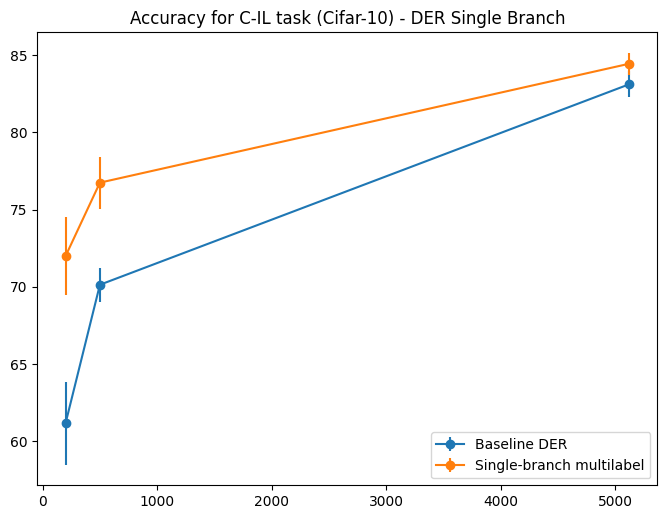

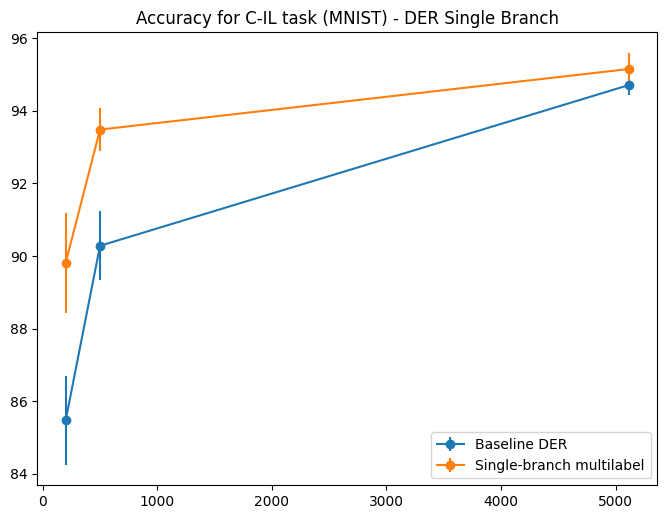

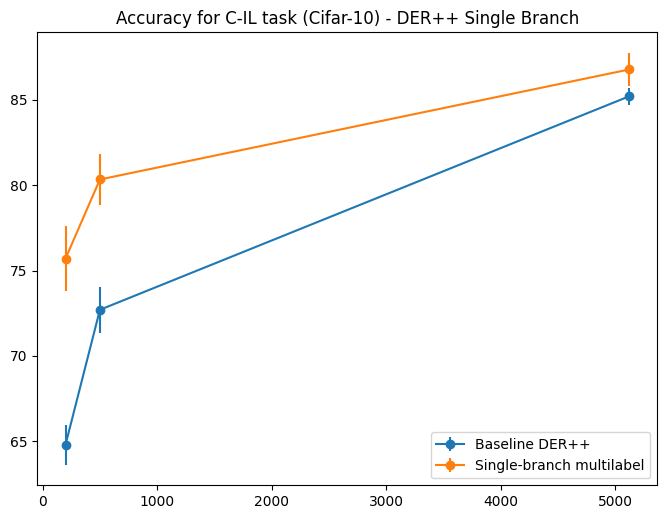

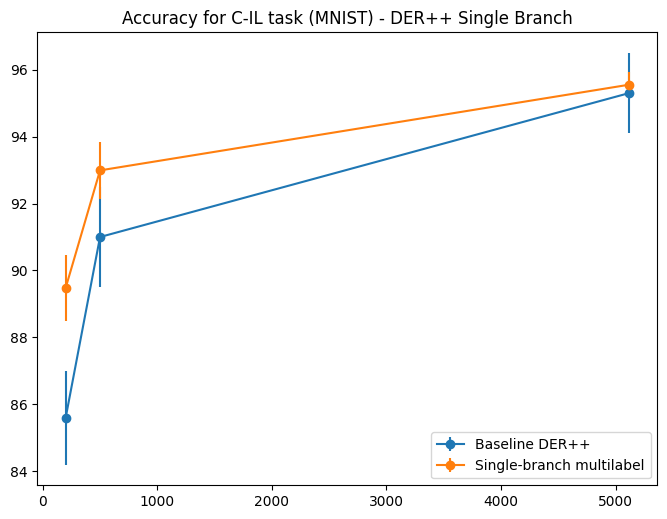

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torchvision
import statistics

# Accuratezze per il C-IL (Cifar-10)
results_baseline_cifar = [[59.3, 60.2, 61.2, 61.0, 59.7, 58.5, 65.9, 66.1, 60.0, 59.6], 
                          [69.3, 68.2, 71.5, 71.0, 69.2, 69.0, 70.8, 71.2, 70.7, 70.4], 
                          [83.1, 83.2, 84.2, 82.9, 81.9, 84.6, 82.9, 83.1, 82.0, 83.2]] # 200 - 500 - 5120
results_baseline_cifar_mean = []
results_baseline_cifar_std = []

results_baseline_derpp_cifar_mean = [64.8, 72.7, 85.2]
results_baseline_derpp_cifar_std = [1.17, 1.36, 0.49]

results_multi_label_cifar = [[73.8, 66.6, 71.9, 72.8, 71.5, 72.8, 75, 70.5, 70.1, 74.8], 
                             [74.6, 73.6, 77.1, 77, 77, 77, 76.9, 79, 79, 76.2], 
                             [83.1, 85.3, 84.6, 84.2, 84.2, 84.7, 84.8, 85.2, 84.8, 83.5]] # 200 - 500 - 5120
results_multi_label_cifar_mean = []
results_multi_label_cifar_std = []

results_multi_label_derpp_cifar = [[79, 74.9, 73.4, 75.7, 74.2, 76.5, 78.4, 76.5, 75, 73.4], 
                             [79, 82, 81.8, 81.4, 80.5, 80.2, 80.2, 78, 78.2, 82], 
                             [85, 86.4, 87.5, 87.5, 87.8, 87, 86.6, 87.7, 85.3, 86.9]] # 200 - 500 - 5120
results_multi_label_derpp_cifar_mean = []
results_multi_label_derpp_cifar_std = []

buffer_size = [200, 500, 5120]

# Accuratezze per il C-IL (MNIST)
results_baseline_mnist = [[87.1, 85.4, 86.1, 84, 86.3, 86.5, 86.6, 84.8, 83.8, 84.1], 
                          [91.1, 90, 89.3, 90.4, 88.6, 89.6, 91.5, 91.5, 90.2, 90.6], 
                          [95, 94.5, 94.4, 94.8, 94.9, 95.1, 94.6, 94.8, 94.8, 94.2]] # 200 - 500 - 5120
results_baseline_mnist_mean = []
results_baseline_mnist_std = []

results_baseline_derpp_mnist_mean = [85.6, 91.0, 95.3]
results_baseline_derpp_mnist_std = [1.4, 1.49, 1.2]

results_multi_label_mnist = [[90.9, 91.1, 90, 90.2, 88.7, 91.5, 90.6, 88.9, 87, 89.2], 
                             [93.9, 93.7, 93.6, 93.3, 92.4, 93, 93.7, 93, 93.7, 94.5], 
                             [95.5, 95.6, 94.6, 94.7, 95.5, 94.5, 94.9, 95.5, 95.1, 95.6]] # 200 - 500 - 5120
results_multi_label_mnist_mean = []
results_multi_label_mnist_std = []

results_multi_label_derpp_mnist = [[89.6, 88.9, 91.5, 88.6, 88.8, 91, 88.6, 89.1, 89.4, 89.3], 
                             [93.6, 93.2, 92, 93.4, 91.1, 93.2, 93.2, 92.8, 93.4, 94], 
                             [95.6, 94.9, 96, 95.1, 95.6, 95.7, 95.2, 95.6, 95.9, 95.9]] # 200 - 500 - 5120
results_multi_label_derpp_mnist_mean = []
results_multi_label_derpp_mnist_std = []

for i in range(len(results_baseline_mnist)):
  results_baseline_mnist_mean.append(statistics.mean(results_baseline_mnist[i]))
  results_baseline_mnist_std.append(statistics.stdev(results_baseline_mnist[i]))
    
for i in range(len(results_baseline_cifar)):
  results_baseline_cifar_mean.append(statistics.mean(results_baseline_cifar[i]))
  results_baseline_cifar_std.append(statistics.stdev(results_baseline_cifar[i]))

for i in range(len(results_multi_label_cifar)):
  results_multi_label_cifar_mean.append(statistics.mean(results_multi_label_cifar[i]))
  results_multi_label_cifar_std.append(statistics.stdev(results_multi_label_cifar[i]))
    
for i in range(len(results_multi_label_derpp_cifar)):
  results_multi_label_derpp_cifar_mean.append(statistics.mean(results_multi_label_derpp_cifar[i]))
  results_multi_label_derpp_cifar_std.append(statistics.stdev(results_multi_label_derpp_cifar[i]))

for i in range(len(results_multi_label_mnist)):
  results_multi_label_mnist_mean.append(statistics.mean(results_multi_label_mnist[i]))
  results_multi_label_mnist_std.append(statistics.stdev(results_multi_label_mnist[i]))
    
for i in range(len(results_multi_label_derpp_mnist)):
  results_multi_label_derpp_mnist_mean.append(statistics.mean(results_multi_label_derpp_mnist[i]))
  results_multi_label_derpp_mnist_std.append(statistics.stdev(results_multi_label_derpp_mnist[i]))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_cifar_mean, yerr=results_baseline_cifar_std, marker = "o", label='Baseline DER')
plt.errorbar(buffer_size, results_multi_label_cifar_mean, yerr=results_multi_label_cifar_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for C-IL task (Cifar-10) - DER Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_mnist_mean, yerr=results_baseline_mnist_std, marker = "o", label='Baseline DER')
plt.errorbar(buffer_size, results_multi_label_mnist_mean, yerr=results_multi_label_mnist_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for C-IL task (MNIST) - DER Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_derpp_cifar_mean, yerr=results_baseline_derpp_cifar_std, marker = "o", label='Baseline DER++')
plt.errorbar(buffer_size, results_multi_label_derpp_cifar_mean, yerr=results_multi_label_derpp_cifar_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for C-IL task (Cifar-10) - DER++ Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_derpp_mnist_mean, yerr=results_baseline_derpp_mnist_std, marker = "o", label='Baseline DER++')
plt.errorbar(buffer_size, results_multi_label_derpp_mnist_mean, yerr=results_multi_label_derpp_mnist_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for C-IL task (MNIST) - DER++ Single Branch")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torchvision
import statistics

# Accuratezze per il T-IL (Cifar-10)
results_baseline_cifar = [[89.9, 90.4, 90.9, 89.5, 92.0, 90.9, 91.7, 91.6, 91.8, 90.8], 
                          [93.2, 91.8, 93.9, 93.4, 92.5, 92.9, 93.0, 93.0, 93.1, 93.2], 
                          [95.7, 95.2, 95.4, 95.6, 95.0, 95.1, 94.4, 95.6, 95.4, 95.1]] # 200 - 500 - 5120
results_baseline_cifar_mean = []
results_baseline_cifar_std = []

results_baseline_derpp_cifar_mean = [91.9, 93.8, 96.1]
results_baseline_derpp_cifar_std = [0.6, 0.5, 0.21]

results_multi_label_cifar = [[79.9, 80.7, 80.8, 78.9, 79.5, 79.2, 81.3, 77.8, 75.9, 81.3], 
                             [82.8, 77.5, 83.2, 82.5, 83.4, 82.9, 83, 84.1, 83.4, 82.4], 
                             [88.8, 89.5, 89.2, 89, 89.6, 89.3, 88.8, 89.4, 89.1, 88.9]] # 200 - 500 - 5120
results_multi_label_cifar_mean = []
results_multi_label_cifar_std = []

results_multi_label_derpp_cifar = [[85.8, 80.7, 79.2, 81.4, 81.4, 84.9, 84.2, 82.8, 80.7, 78.8], 
                             [83.6, 87.4, 86.3, 86.7, 85.4, 85.4, 85.3, 85.8, 83.6, 85.9], 
                             [91.2, 92.2, 91.8, 91.7, 92.5, 91.4, 91.3, 92.2, 91.8, 92.1]] # 200 - 500 - 5120
results_multi_label_derpp_cifar_mean = []
results_multi_label_derpp_cifar_std = []

buffer_size = [200, 500, 5120]

# Accuratezze per il T-IL (MNIST)
results_baseline_mnist = [[98.7, 98.6, 98.3, 98.5, 98.5, 98.6, 98.6, 98.4, 98.6, 98.6], 
                          [98.6, 98.9, 98.6, 98.7, 98.4, 98.5, 98.5, 98.7, 98.6, 98.8], 
                          [99.2, 99.1, 99.1, 99, 99, 99.1, 99, 99.2, 98.9, 99]] # 200 - 500 - 5120
results_baseline_mnist_mean = []
results_baseline_mnist_std = []

results_baseline_derpp_mnist_mean = [98.7, 98.9, 99.4]
results_baseline_derpp_mnist_std = [0.28, 0.27, 0.07]

results_multi_label_mnist = [[96.3, 96.3, 95.2, 96, 96, 96.2, 95.4, 96.4, 96.4, 94.6], 
                             [97.6, 97.3, 97.7, 97.2, 96.8, 97.7, 97.4, 97.2, 97.6, 97.5], 
                             [98.3, 98.6, 98.2, 98.4, 98.1, 97.8, 98.8, 98.7, 98.5, 98.4]] # 200 - 500 - 5120
results_multi_label_mnist_mean = []
results_multi_label_mnist_std = []

results_multi_label_derpp_mnist = [[97.1, 96.6, 97.2, 96.2, 96.3, 96.7, 93.6, 95.8, 96.1, 95.1], 
                             [97.6, 97.5, 97.7, 97.5, 97.7, 97.7, 98, 97.7, 97.8, 97.5], 
                             [98.8, 98.4, 98.8, 98.4, 98.6, 98.9, 98.4, 98.7, 98.7, 98.8]] # 200 - 500 - 5120
results_multi_label_derpp_mnist_mean = []
results_multi_label_derpp_mnist_std = []

for i in range(len(results_baseline_mnist)):
  results_baseline_mnist_mean.append(statistics.mean(results_baseline_mnist[i]))
  results_baseline_mnist_std.append(statistics.stdev(results_baseline_mnist[i]))
    
for i in range(len(results_baseline_cifar)):
  results_baseline_cifar_mean.append(statistics.mean(results_baseline_cifar[i]))
  results_baseline_cifar_std.append(statistics.stdev(results_baseline_cifar[i]))

for i in range(len(results_multi_label_cifar)):
  results_multi_label_cifar_mean.append(statistics.mean(results_multi_label_cifar[i]))
  results_multi_label_cifar_std.append(statistics.stdev(results_multi_label_cifar[i]))
    
for i in range(len(results_multi_label_derpp_cifar)):
  results_multi_label_derpp_cifar_mean.append(statistics.mean(results_multi_label_derpp_cifar[i]))
  results_multi_label_derpp_cifar_std.append(statistics.stdev(results_multi_label_derpp_cifar[i]))

for i in range(len(results_multi_label_mnist)):
  results_multi_label_mnist_mean.append(statistics.mean(results_multi_label_mnist[i]))
  results_multi_label_mnist_std.append(statistics.stdev(results_multi_label_mnist[i]))

for i in range(len(results_multi_label_derpp_mnist)):
  results_multi_label_derpp_mnist_mean.append(statistics.mean(results_multi_label_derpp_mnist[i]))
  results_multi_label_derpp_mnist_std.append(statistics.stdev(results_multi_label_derpp_mnist[i]))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_cifar_mean, yerr=results_baseline_cifar_std, marker = "o", label='Baseline DER')
plt.errorbar(buffer_size, results_multi_label_cifar_mean, yerr=results_multi_label_cifar_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for T-IL task (Cifar-10) - DER Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_mnist_mean, yerr=results_baseline_mnist_std, marker = "o", label='Baseline DER')
plt.errorbar(buffer_size, results_multi_label_mnist_mean, yerr=results_multi_label_mnist_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for T-IL task (MNIST) - DER Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_derpp_cifar_mean, yerr=results_baseline_derpp_cifar_std, marker = "o", label='Baseline DER++')
plt.errorbar(buffer_size, results_multi_label_derpp_cifar_mean, yerr=results_multi_label_derpp_cifar_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for T-IL task (Cifar-10) - DER++ Single Branch")

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(buffer_size, results_baseline_derpp_mnist_mean, yerr=results_baseline_derpp_mnist_std, marker = "o", label='Baseline DER++')
plt.errorbar(buffer_size, results_multi_label_derpp_mnist_mean, yerr=results_multi_label_derpp_mnist_std, marker = "o", label='Single-branch multilabel')
plt.legend(loc='lower right')
plt.title("Accuracy for T-IL task (MNIST) - DER++ Single Branch")

Text(0.5, 1.0, 'Accuracy for T-IL task (MNIST) - DER++ Single Branch')